In [63]:
library(data.table) 
library(ggplot2)
library(plyr)
library(ComplexUpset)
library(repr)
library(Seurat)
library(pheatmap)
library(grid)

## Visualisation of HTODemux result
### tSNE plot

Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
PC_ 1 
Positive:  Hash454-TotalSeqA, Hash451-TotalSeqA, Hash455-TotalSeqA 
Negative:  Hash452-TotalSeqA, Hash456-TotalSeqA, Hash453-TotalSeqA 
PC_ 2 
Positive:  Hash456-TotalSeqA, Hash455-TotalSeqA, Hash453-TotalSeqA 
Negative:  Hash451-TotalSeqA, Hash452-TotalSeqA, Hash454-TotalSeqA 
PC_ 3 
Positive:  Hash451-TotalSeqA, Hash456-TotalSeqA, Hash455-TotalSeqA 
Negative:  Hash452-TotalSeqA, Hash454-TotalSeqA, Hash453-TotalSeqA 
PC_ 4 
Positive:  Hash456-TotalSeqA, Hash452-TotalSeqA, Hash454-TotalSe

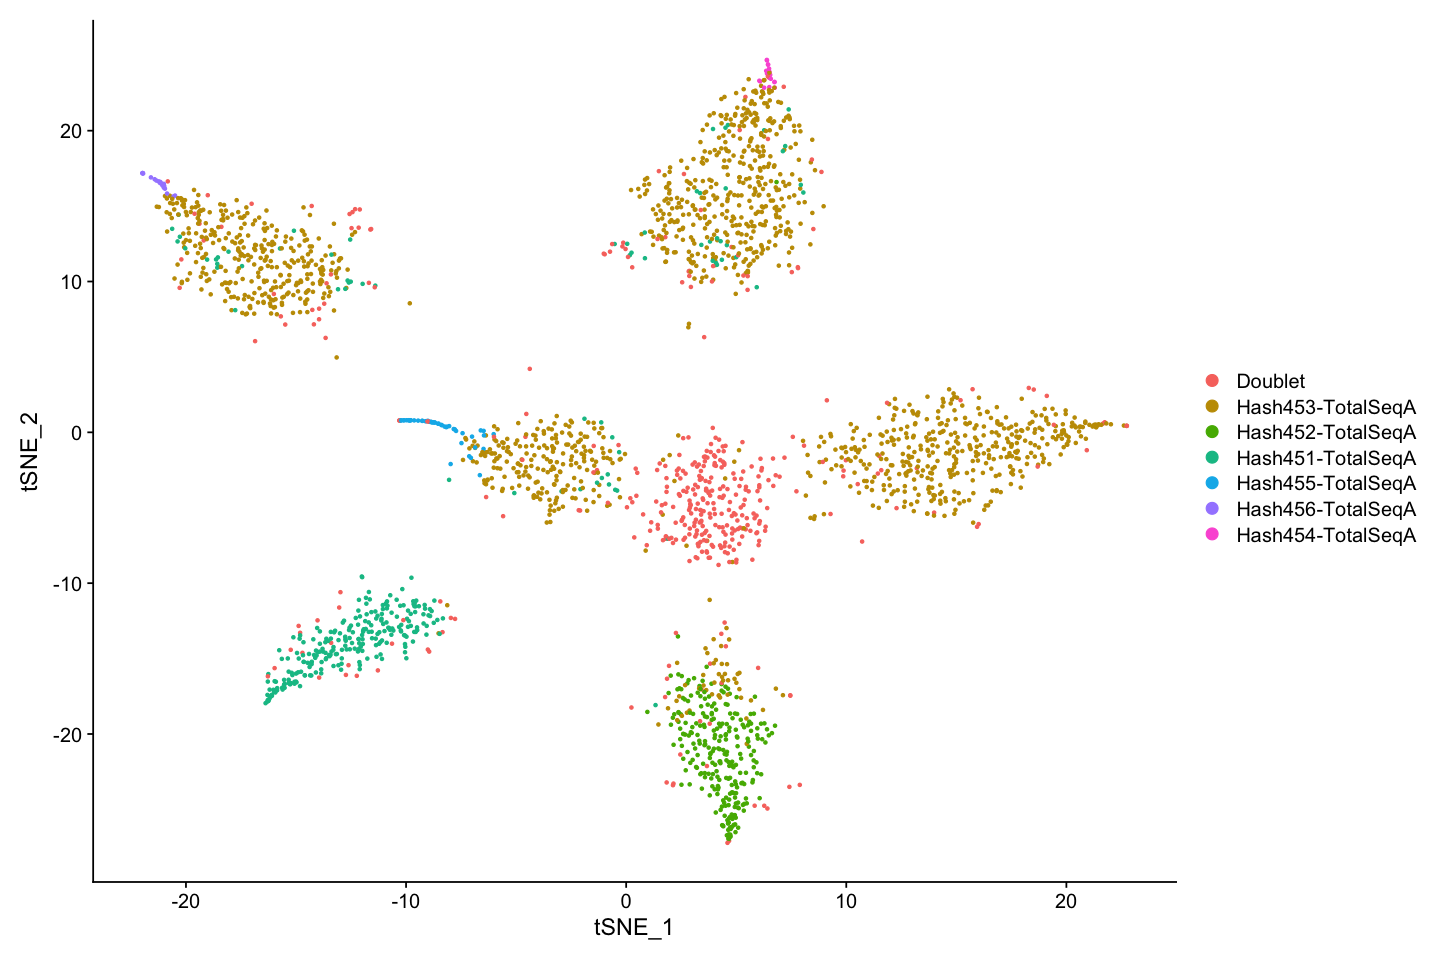

In [64]:
# Load htodemux result from an rds object
htodemux_gx38 <- readRDS("../data/pipeline_output/gx38/htodemux.rds")

# Subset the object, remove negative droplets
htodemux_gx38.subset <- subset(htodemux_gx38, idents = "Negative", invert = TRUE)

# Calculate a tSNE embedding of the HTO data
DefaultAssay(htodemux_gx38.subset) <- "HTO"
htodemux_gx38.subset <- ScaleData(htodemux_gx38.subset, features = rownames(htodemux_gx38.subset),
    verbose = FALSE)
htodemux_gx38.subset <- RunPCA(htodemux_gx38.subset, features = rownames(htodemux_gx38.subset), approx = FALSE)
htodemux_gx38.subset <- RunTSNE(htodemux_gx38.subset, dims = 1:6, perplexity = 100)

# Change plot size to 12 x 8
options(repr.plot.width=12, repr.plot.height=8)

DimPlot(htodemux_gx38.subset)

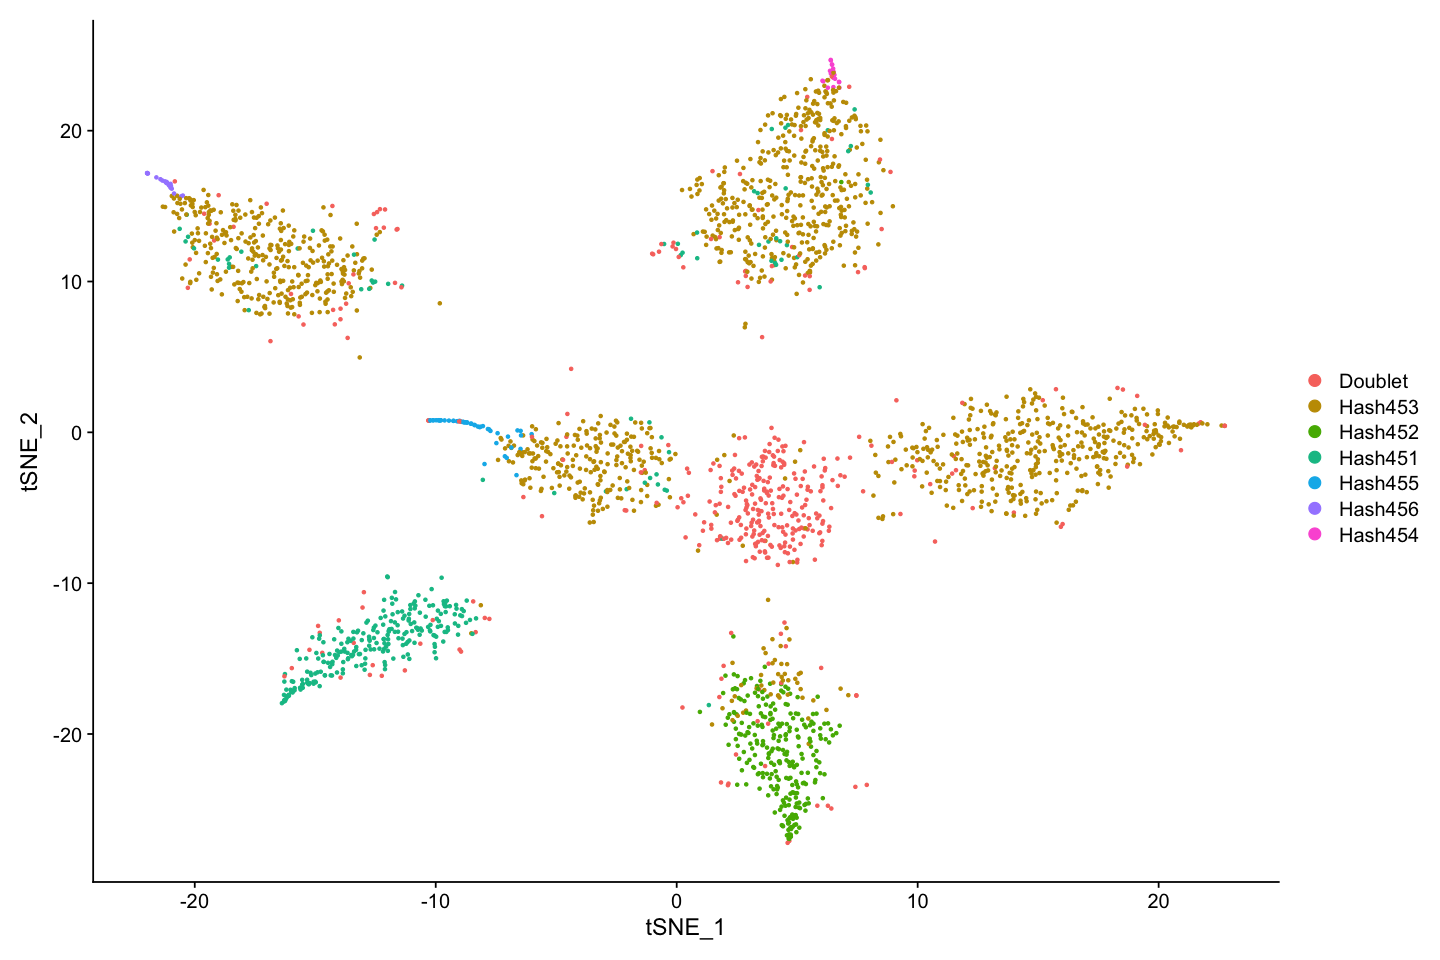

In [65]:
# Rename the features
DimPlot(htodemux_gx38.subset) + scale_color_hue(labels = c("Doublet", paste0("Hash45", c(3,2,1,5,6,4))))
# ggsave("S1-tsne-gx38.png", dpi = 300, height = 5, width = 8)

### ridge plot

Picking joint bandwidth of 0.0227

Picking joint bandwidth of 0.0296

Picking joint bandwidth of 0.0259

Picking joint bandwidth of 0.0248

Picking joint bandwidth of 0.0615

Picking joint bandwidth of 0.0324



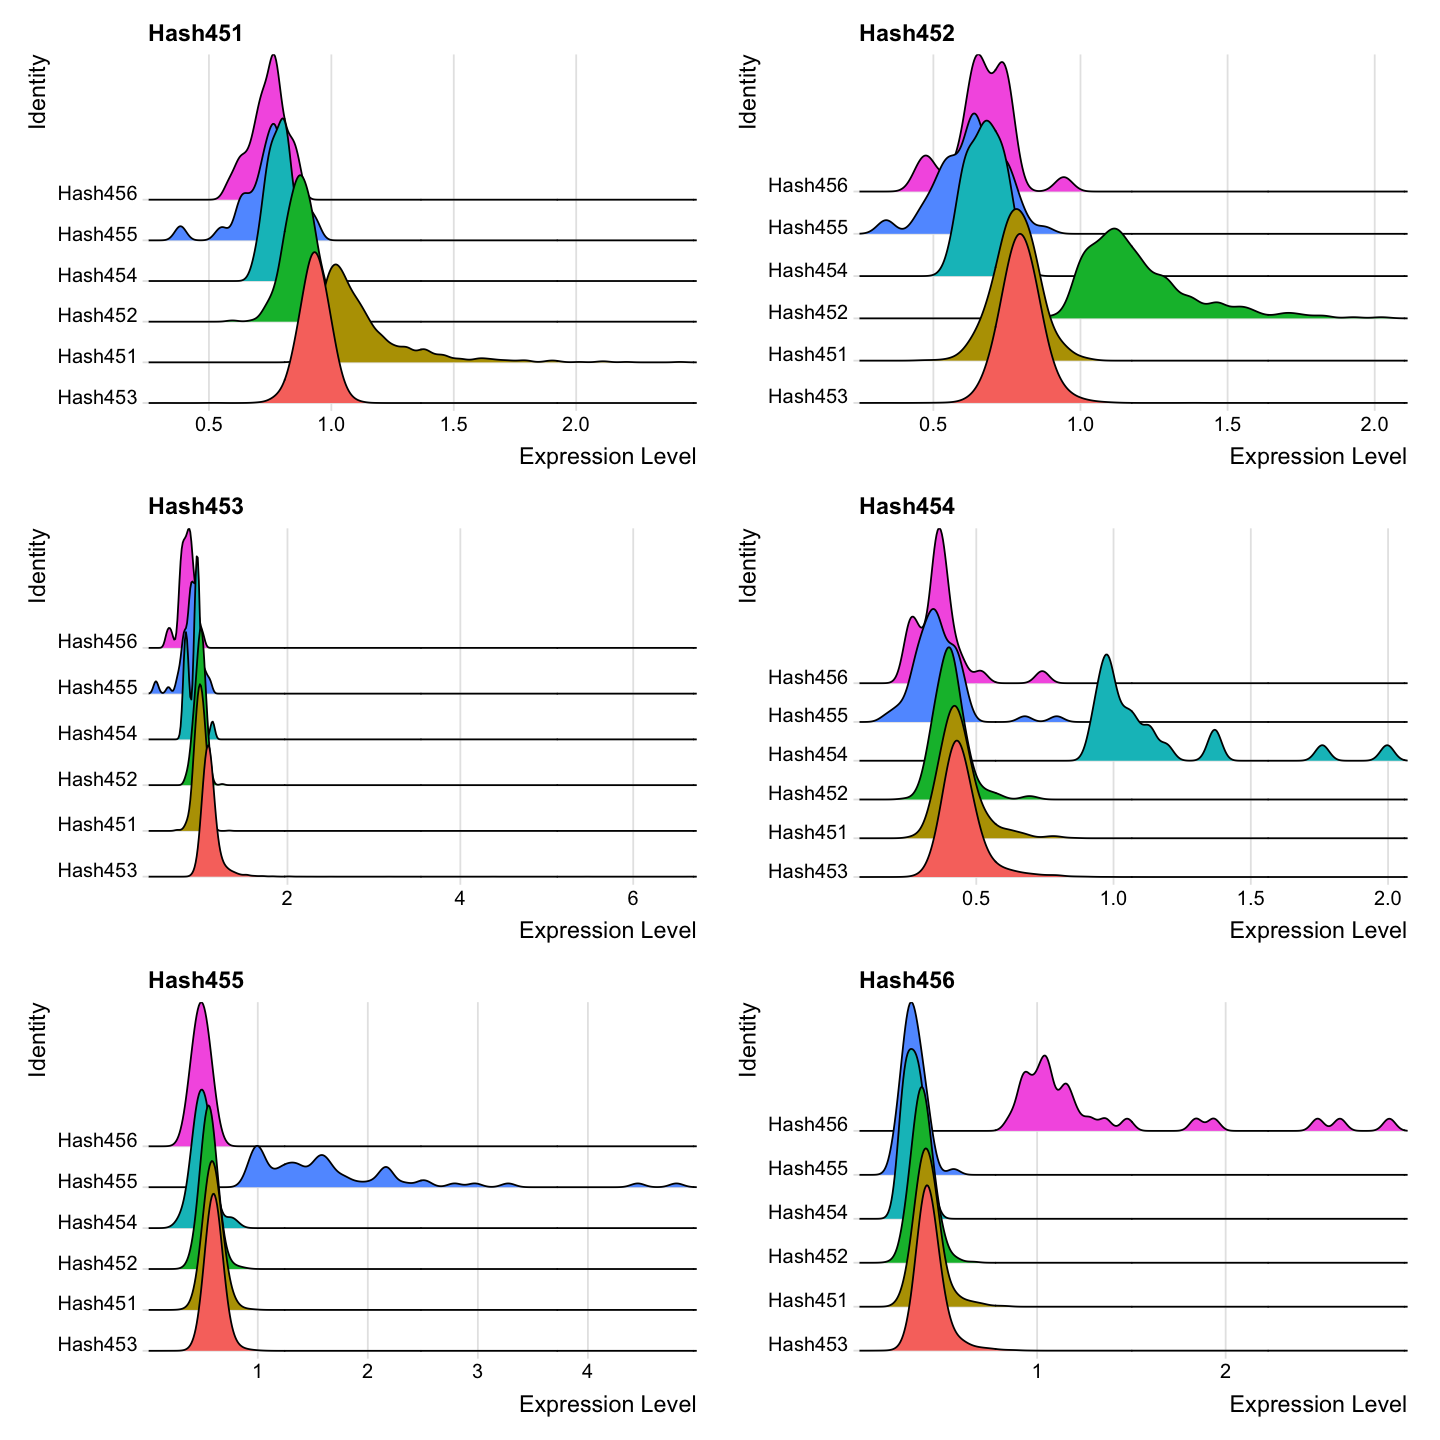

In [66]:
# Change plot size to 12 x 12
options(repr.plot.width=12, repr.plot.height=12)

# Rename features
htodemux_gx38[["HTO"]]@counts@Dimnames[[1]] <- paste0("Hash45", 1:6)
dimnames(htodemux_gx38[["HTO"]]@data)[[1]] <- paste0("Hash45", 1:6)
htodemux_gx38 <- RenameIdents(htodemux_gx38, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')
# Group cells based on the max HTO signal
Idents(htodemux_gx38) <- "HTO_maxID"
htodemux_gx38 <- RenameIdents(htodemux_gx38, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')

RidgePlot(htodemux_gx38, assay = "HTO", features = rownames(htodemux_gx38[["HTO"]]), ncol = 2)
# ggsave("S2-ridge-gx38.png", dpi = 300, height = 7, width = 9)

### heatmap

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


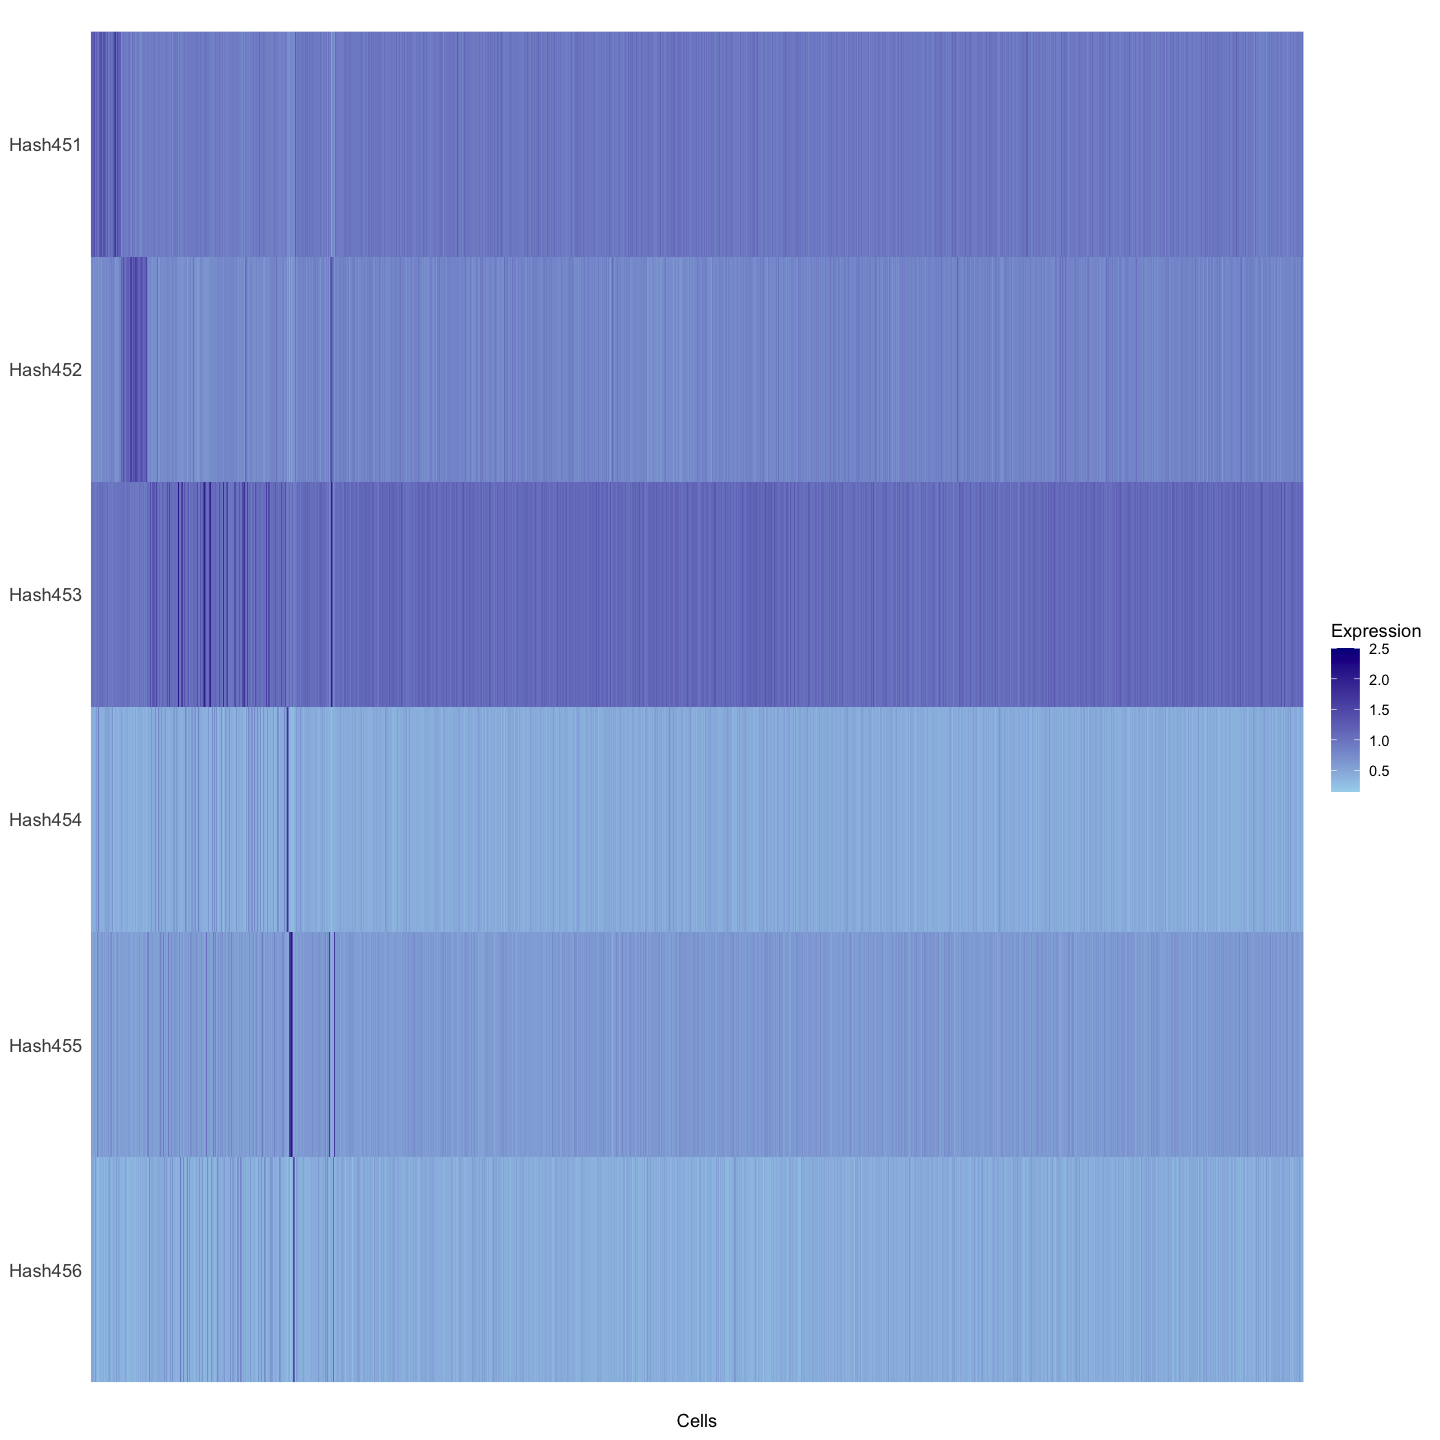

In [67]:
# Rename features
htodemux_gx38[["HTO_classification"]]$HTO_classification <- gsub('-TotalSeqA', '', htodemux_gx38[["HTO_classification"]]$HTO_classification)

HTOHeatmap(htodemux_gx38, assay = "HTO", ncells=12585) + xlab("Cells") + scale_fill_gradient(low = "#a6d5ed", high = "darkblue", guide = "colorbar") + 
    theme(axis.text=element_text(size=11))
# ggsave("S3-heatmap-gx38.png", dpi = 300, height = 5, width = 7)

### Load hashing deconvolution results

In [68]:
# Load hashing deconvolution results
hash_gx38_classi <-fread("../data/pipeline_output/gx38/hash_classification_all.csv")

# Remove the trial ID
colnames(hash_gx38_classi) <- gsub("_1", "", colnames(hash_gx38_classi))

# Subset by only those cells detected by RNA
white_list_gx38 <- fread("../data/dataset/barcodes_gx38.tsv", header = F)$V1
hash_gx38_classi <- hash_gx38_classi[Barcode %in% white_list_gx38,]

head(hash_gx38_classi)

Barcode,demuxem,hashedDrops,hashsolo,htodemux,multiseq,solo
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATGAGA-1,negative,negative,doublet,negative,singlet,singlet
AAACCCAAGGTACCTT-1,negative,negative,doublet,negative,negative,singlet
AAACCCAAGTCATTGC-1,singlet,negative,doublet,negative,singlet,singlet
AAACCCAAGTTGGAGC-1,singlet,negative,doublet,negative,singlet,doublet
AAACCCACAAGGCTTT-1,negative,negative,doublet,negative,singlet,singlet
AAACCCACACACAGCC-1,doublet,negative,doublet,singlet,doublet,doublet


## Visualisation of hashing deconvolution results

In [69]:
# Reorder the result
summary_hash_gx38 <- melt(hash_gx38_classi, id.vars = "Barcode", variable.name = "Method", 
                          value.name = "Classification")
summary_hash_gx38 <- na.omit(summary_hash_gx38)
summary_hash_gx38 <- as.data.frame(table(summary_hash_gx38[,-1]))
colnames(summary_hash_gx38)[3] <- "Count" 
summary_hash_gx38 <- summary_hash_gx38[order(summary_hash_gx38$Classification, decreasing = T),]
head(summary_hash_gx38)

,Method,Classification,Count
,<fct>,<fct>,<int>
13,demuxem,singlet,5210
14,hashedDrops,singlet,97
15,hashsolo,singlet,1043
16,htodemux,singlet,2124
17,multiseq,singlet,7468
18,solo,singlet,9517


Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


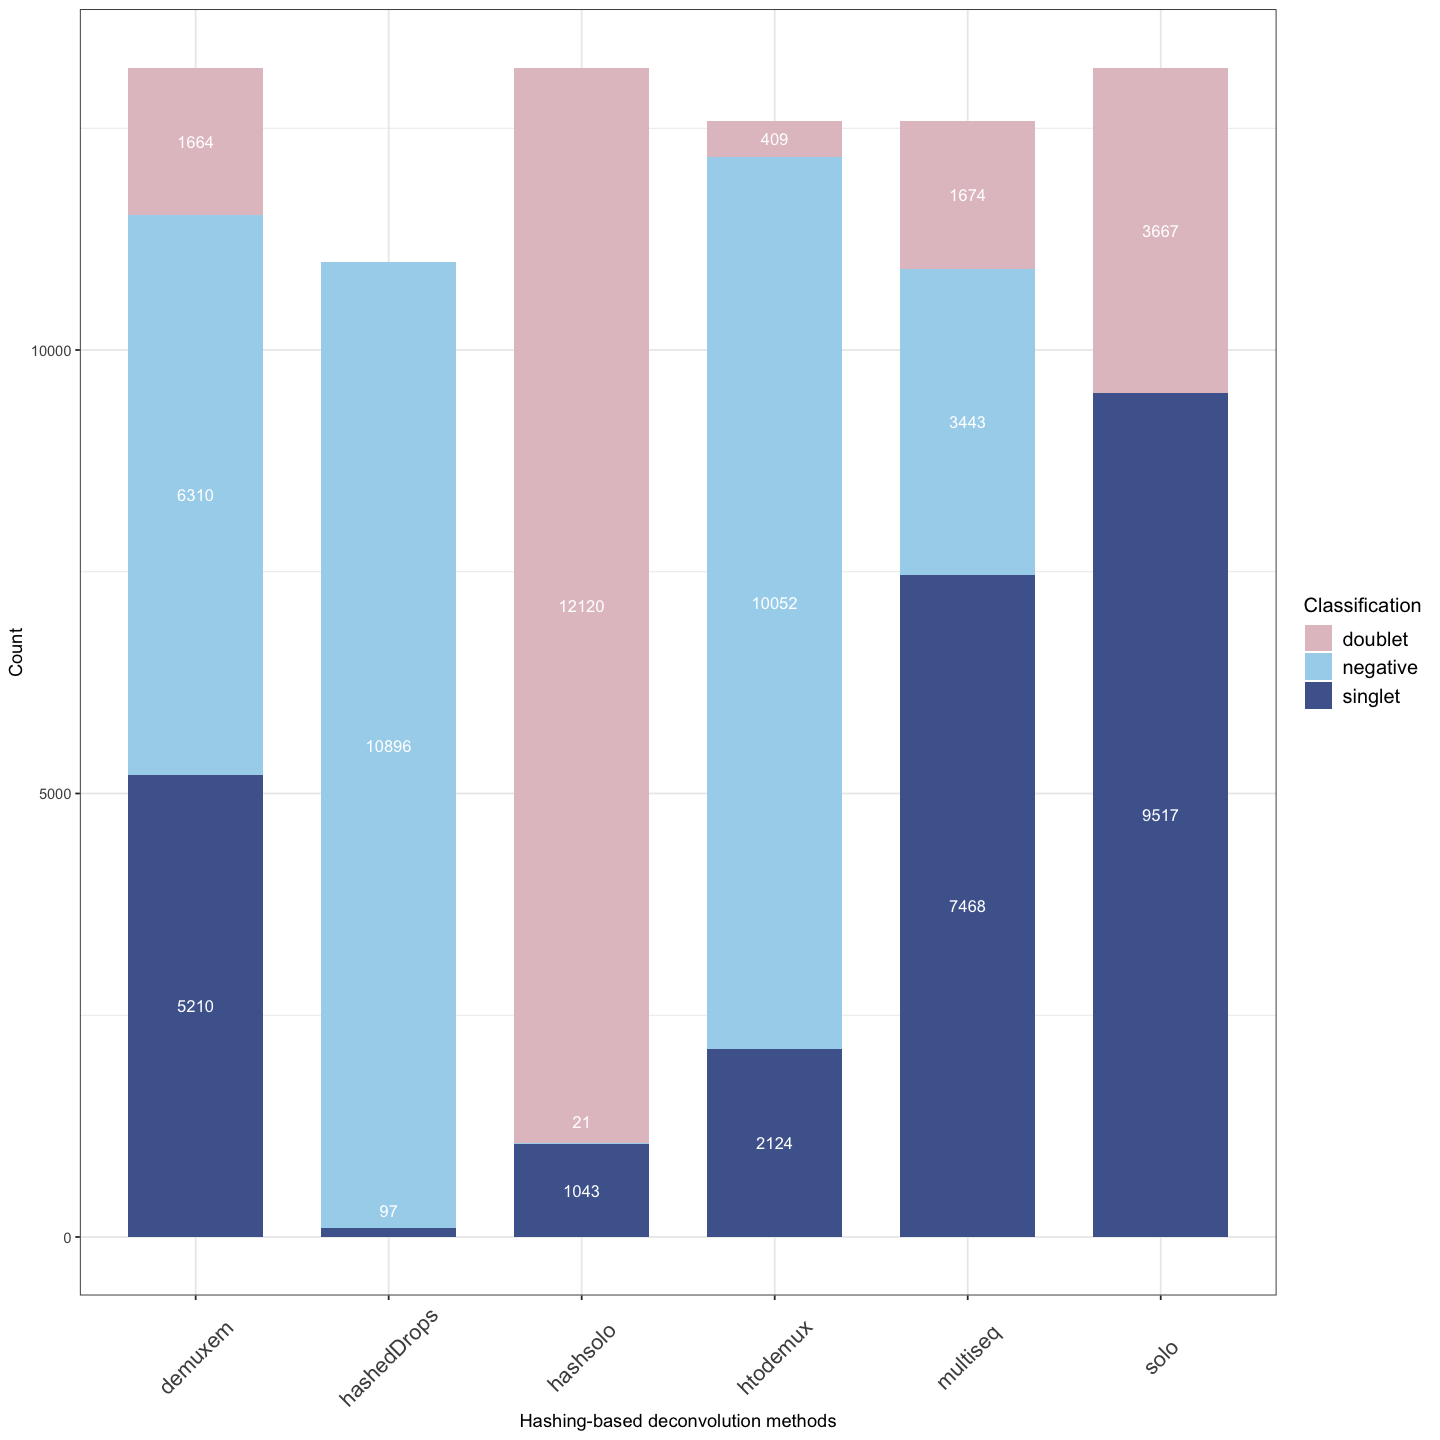

In [70]:
# Determine the y-axis position of labels ylab_pos
summary_hash_gx38_cumsum <- ddply(summary_hash_gx38, "Method", transform, 
                                  label_ypos=cumsum(Count)- 0.5*Count)
# Modify the ylab_pos manually
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method=="hashsolo" & summary_hash_gx38_cumsum$Classification=="negative",]$label_ypos <- 1300
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method=="hashedDrops" & summary_hash_gx38_cumsum$Classification=="singlet",]$label_ypos <- 300

# Avoid showing count 0
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Count==0,]$label_ypos <- NA

# Barplot
ggplot(summary_hash_gx38_cumsum, aes(x=Method, y=Count, fill=Classification)) + geom_bar(stat="identity", width=0.7) +
    scale_fill_manual(values = c("#E2C3C9", "#a6d5ed", "#4e659b")) + theme_bw() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, size = 13),
    legend.text=element_text(size=12),
    legend.title=element_text(size=12)) +
    xlab("Hashing-based deconvolution methods") +
    geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=3.5)

ggsave("S4-hash-bar-gx38.png", dpi = 300, height = 5, width = 7)

### Define a function to convert the result to a binary matrix 

In [71]:
convert2binary <- function(assignment, identity){
    # table in a long format
    assignment_new <- melt(assignment, id.vars=1)
    assignment_new <- na.omit(assignment_new)
 
    # Subset to identity
    assignment_new <- assignment_new[assignment_new$value==identity,]
    assignment_new <- assignment_new [, -3]

    # table in a wide format
    assignment_new <- dcast(assignment_new, Barcode~variable)
    assignment_new <- as.data.frame(lapply(assignment_new [, -1], as.numeric))

    # turn into a binary matrix
    assignment_new[!is.na(assignment_new)] <- 1
    assignment_new[is.na(assignment_new)] <- 0
    
    return(assignment_new)
}

## Upset plot for droplet classification of hashing deconvolution methods

In [72]:
hash_gx38_classi_new_singlet <- convert2binary(hash_gx38_classi, 'singlet')
head(hash_gx38_classi_new_singlet)

Using 'variable' as value column. Use 'value.var' to override



,demuxem,hashedDrops,hashsolo,htodemux,multiseq,solo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,1,1
2,0,0,0,0,0,1
3,1,0,0,0,1,1
4,1,0,0,0,1,0
5,0,0,0,0,1,1
6,0,0,0,1,0,0


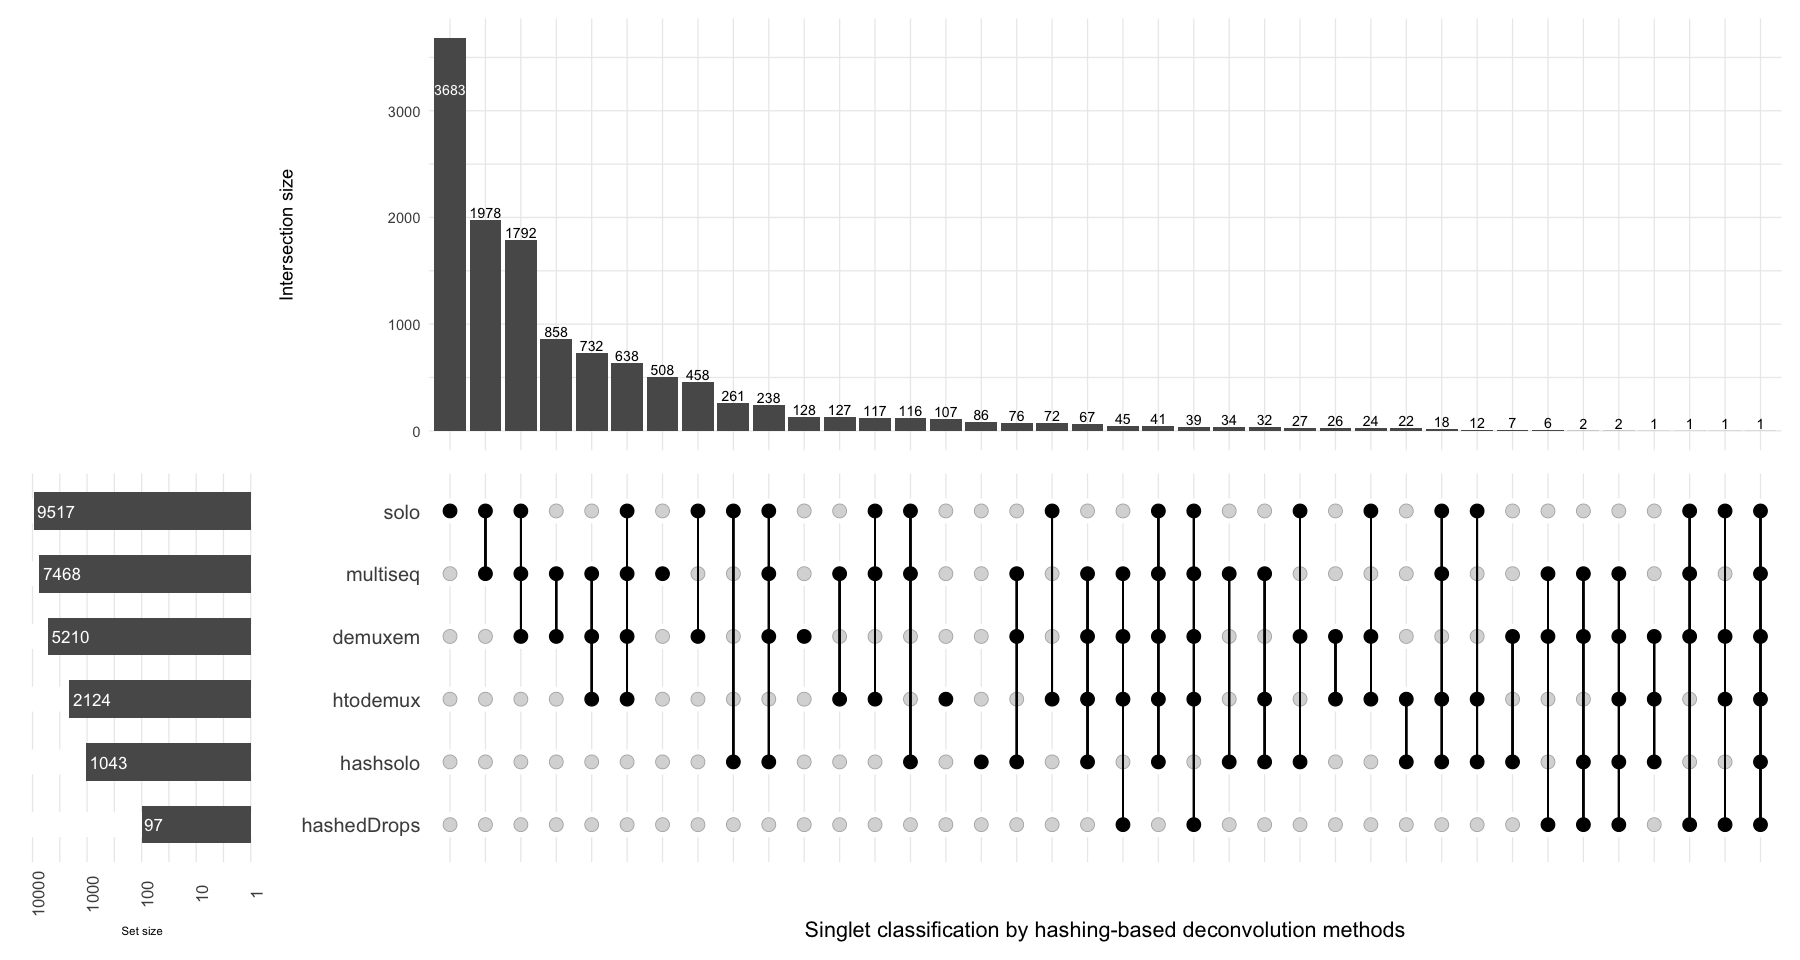

In [73]:
# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# upset plot 
ComplexUpset::upset(hash_gx38_classi_new_singlet, colnames(hash_gx38_classi_new_singlet), width_ratio = 0.15, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1,
                    name="Singlet classification by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=4), hjust = -0.1, 
                                                            stat = 'count', color = 'white', size = 3.6) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 7))+ 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=3))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

# ggsave("S5-upset-hash-singlet-gx38.png", width= 15, height=5, dpi=300)

In [74]:
hash_gx38_classi_new_doublet <- convert2binary(hash_gx38_classi, 'doublet')
head(hash_gx38_classi_new_doublet)

Using 'variable' as value column. Use 'value.var' to override



,demuxem,hashsolo,htodemux,multiseq,solo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,1
5,0,1,0,0,0
6,1,1,0,1,1


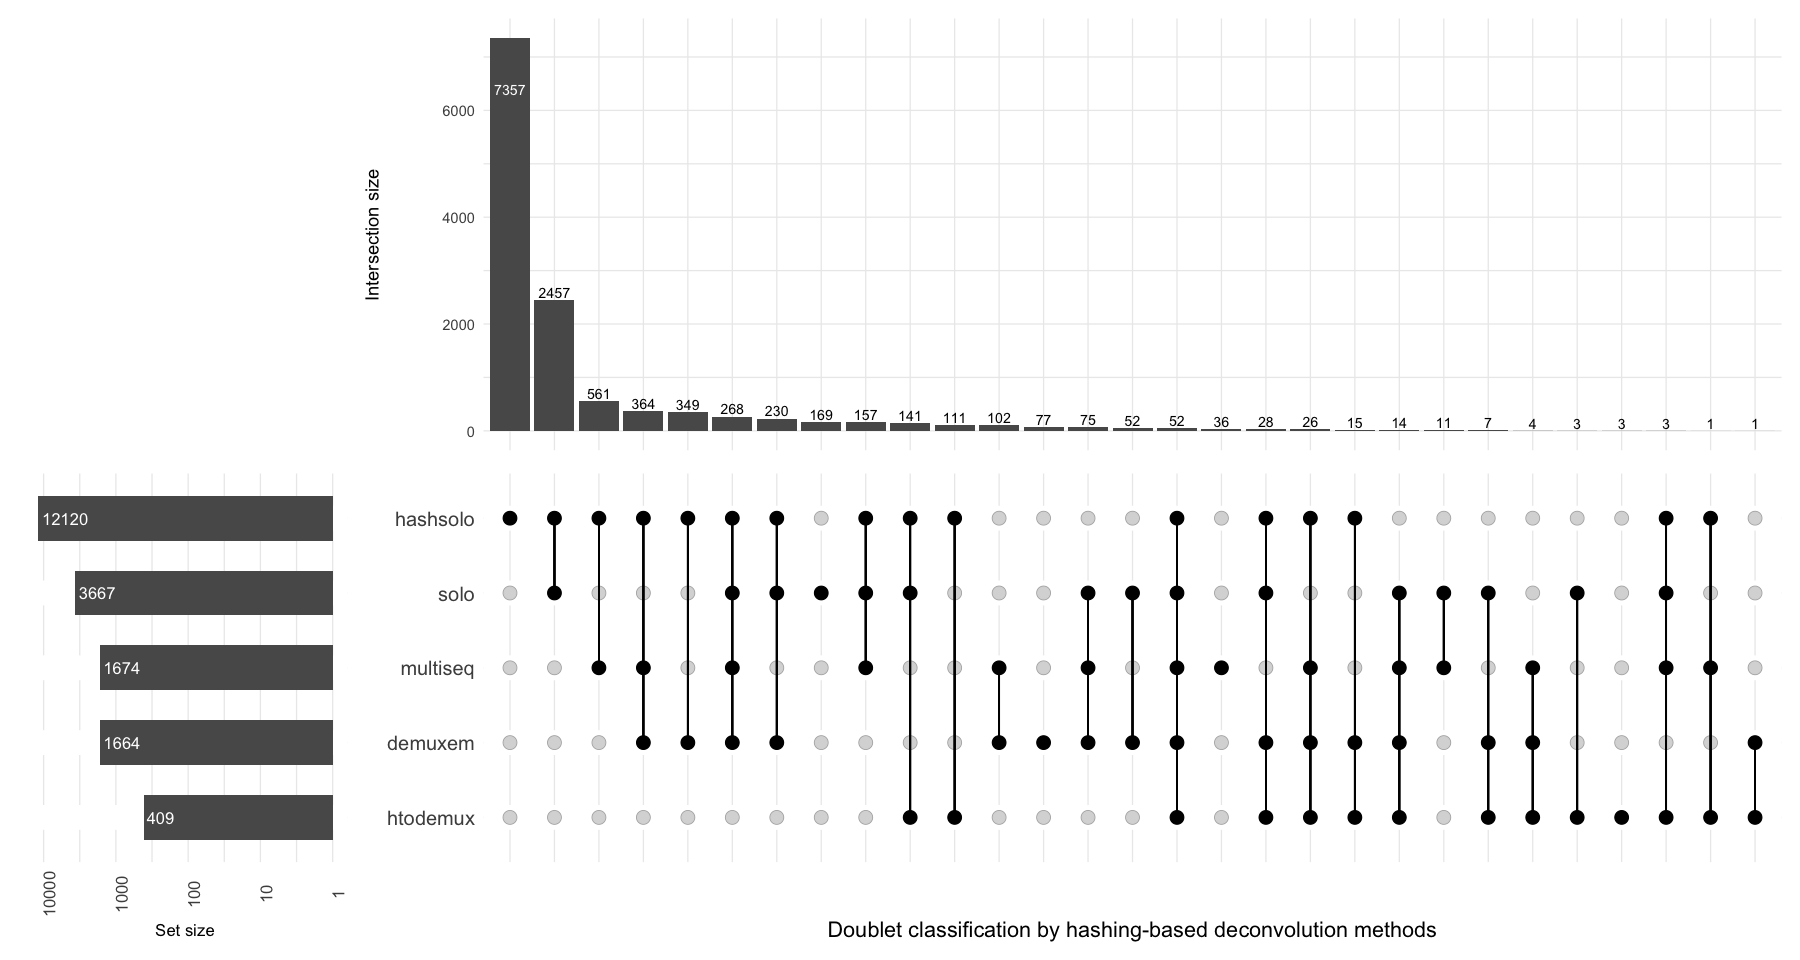

In [75]:
ComplexUpset::upset(hash_gx38_classi_new_doublet, colnames(hash_gx38_classi_new_doublet), width_ratio = 0.2, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Doublet classification by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=3), hjust = -0.1, 
                                                            stat = 'count', color = 'white', size = 3.5) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 10))+ 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=3))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))
# ggsave("S6-upset-hash-doublet-gx38.png", width= 15, height=5, dpi=300)

## Upset plot for hashtag identification of hashing deconvolution methods

In [76]:
# Load hashing deconvolution results
hash_gx38_assign <-fread("../data/pipeline_output/gx38/hash_assignment_all.csv")

# Remove the trial ID
colnames(hash_gx38_assign) <- gsub("_1", "", colnames(hash_gx38_assign))

# Subset by only those cells detected by RNA
hash_gx38_assign <- hash_gx38_assign[Barcode %in% white_list_gx38,]

# Remove TotalSeqA suffix
hash_gx38_assign$htodemux <- gsub("-TotalSeqA", "", hash_gx38_assign$htodemux)
hash_gx38_assign$multiseq <- gsub("-TotalSeqA", "", hash_gx38_assign$multiseq)
hash_gx38_assign$demuxem <- gsub("_TotalSeqA", "", hash_gx38_assign$demuxem)
hash_gx38_assign$hashsolo <- gsub("_TotalSeqA", "", hash_gx38_assign$hashsolo)


head(hash_gx38_assign)

Barcode,demuxem,hashsolo,htodemux,multiseq
<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATGAGA-1,negative,doublet,negative,Hash454
AAACCCAAGGTACCTT-1,negative,doublet,negative,negative
AAACCCAAGTCATTGC-1,Hash454,doublet,negative,Hash454
AAACCCAAGTTGGAGC-1,Hash453,doublet,negative,Hash453
AAACCCACAAGGCTTT-1,negative,doublet,negative,Hash453
AAACCCACACACAGCC-1,doublet,doublet,Hash453,doublet


Using 'variable' as value column. Use 'value.var' to override



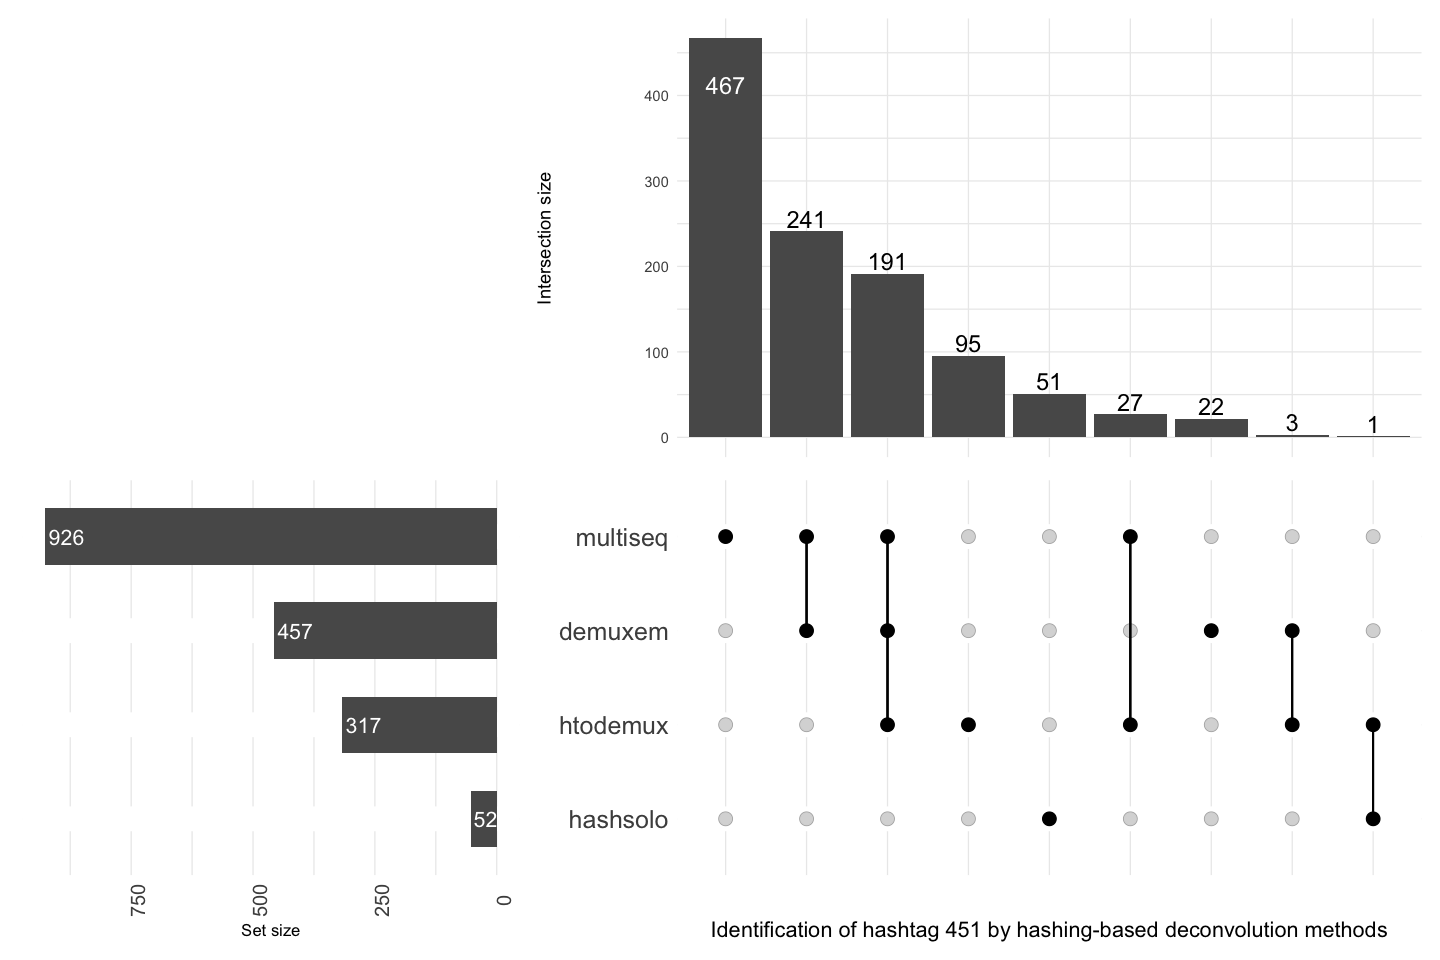

In [77]:
# convert to binary matrix
hash_ht451 <- convert2binary(hash_gx38_assign, 'Hash451')

# Change plot size to 12 x 8
options(repr.plot.width=12, repr.plot.height=8)

ComplexUpset::upset(hash_ht451, colnames(hash_ht451), width_ratio = 0.4, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Identification of hashtag 451 by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=6), hjust = -0.1, 
                                                            stat = 'count', color = 'white', size = 4.5) +
                               theme(axis.text.x = element_text(angle = 90, size=12), text = element_text(size = 10))),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=5))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=15),
                                                                                text=element_text(size=13)))))

# ggsave("S7-upset-hashing-hashtag451-gx38.png", width= 12, height=8, dpi=300)


Using 'variable' as value column. Use 'value.var' to override



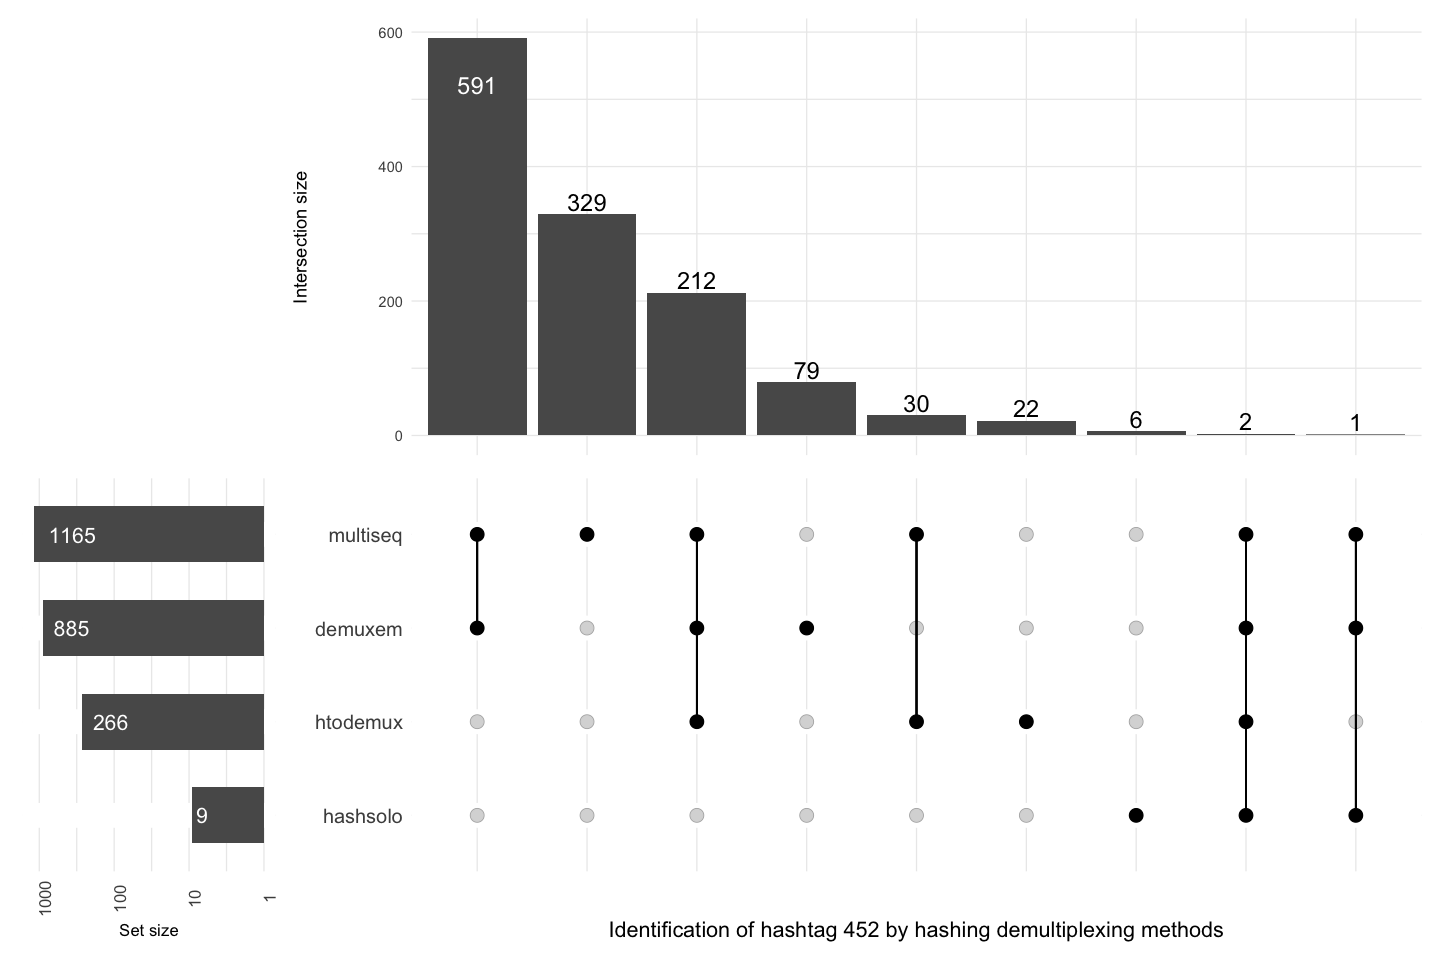

In [78]:
# convert to binary matrix
hash_ht452 <- convert2binary(hash_gx38_assign, 'Hash452')

ComplexUpset::upset(hash_ht452, colnames(hash_ht452), width_ratio = 0.2, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Identification of hashtag 452 by hashing demultiplexing methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=6), hjust = -0.3, 
                                                            stat = 'count', color = 'white', size = 4.5) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 10)) + 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=5))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

# ggsave("S8-upset-hashing-hashtag452-gx38.png", width= 10, height=8, dpi=300)

Using 'variable' as value column. Use 'value.var' to override



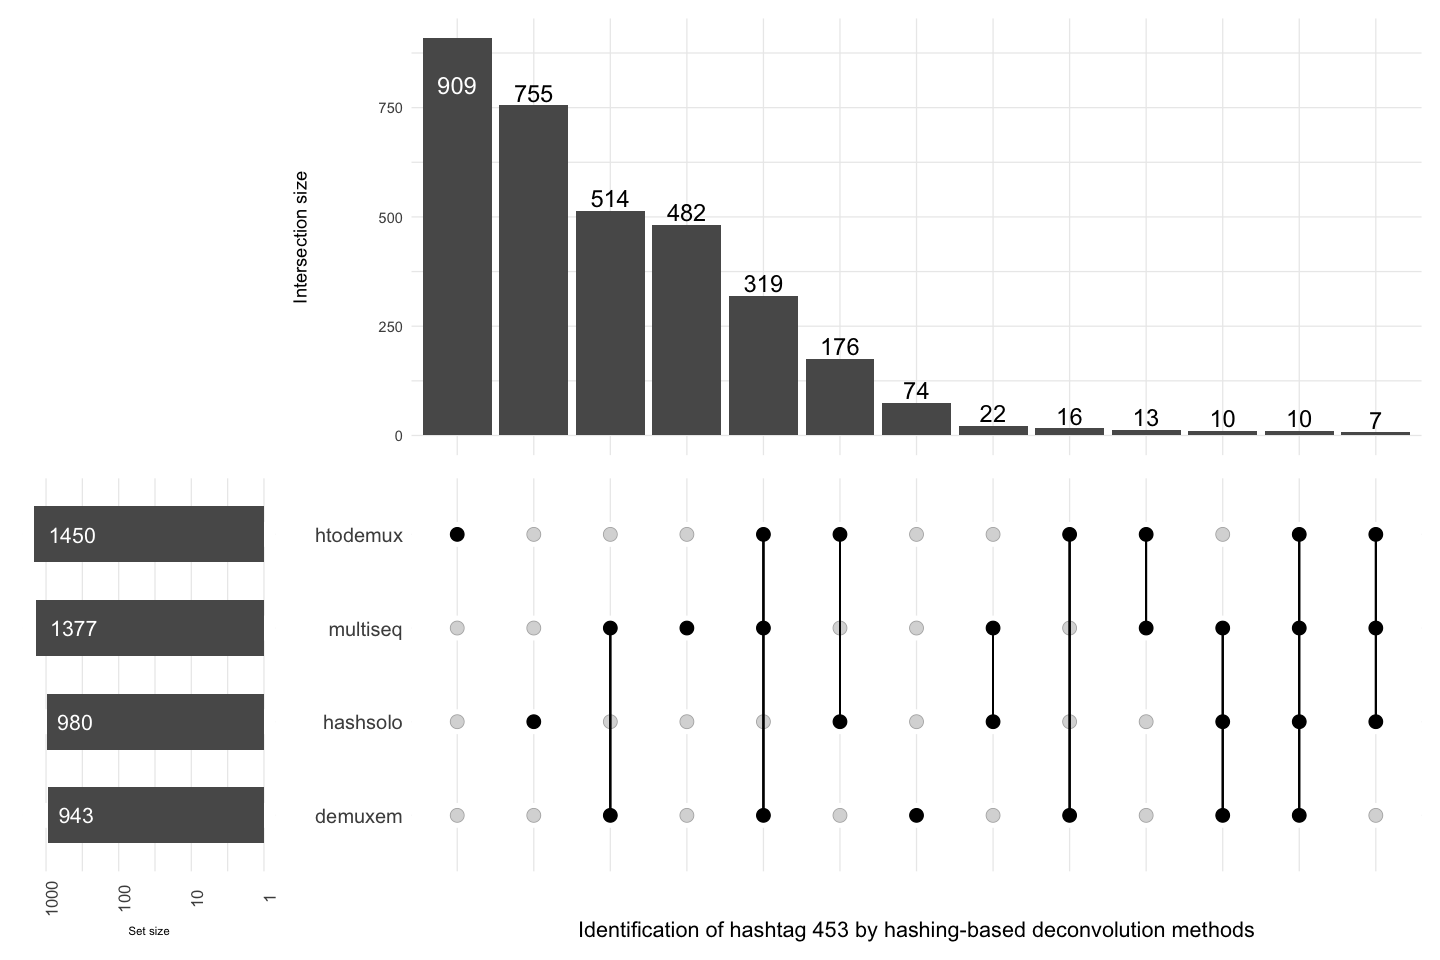

In [79]:
# convert to binary matrix
hash_ht453 <- convert2binary(hash_gx38_assign, 'Hash453')

ComplexUpset::upset(hash_ht453, colnames(hash_ht453), width_ratio = 0.2, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Identification of hashtag 453 by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=6), hjust = -0.3, 
                                                            stat = 'count', color = 'white', size = 4.5) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 7)) + 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=5))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

ggsave("S9-upset-hashing-hashtag453-gx38.png", width= 10, height=8, dpi=300)

Using 'variable' as value column. Use 'value.var' to override



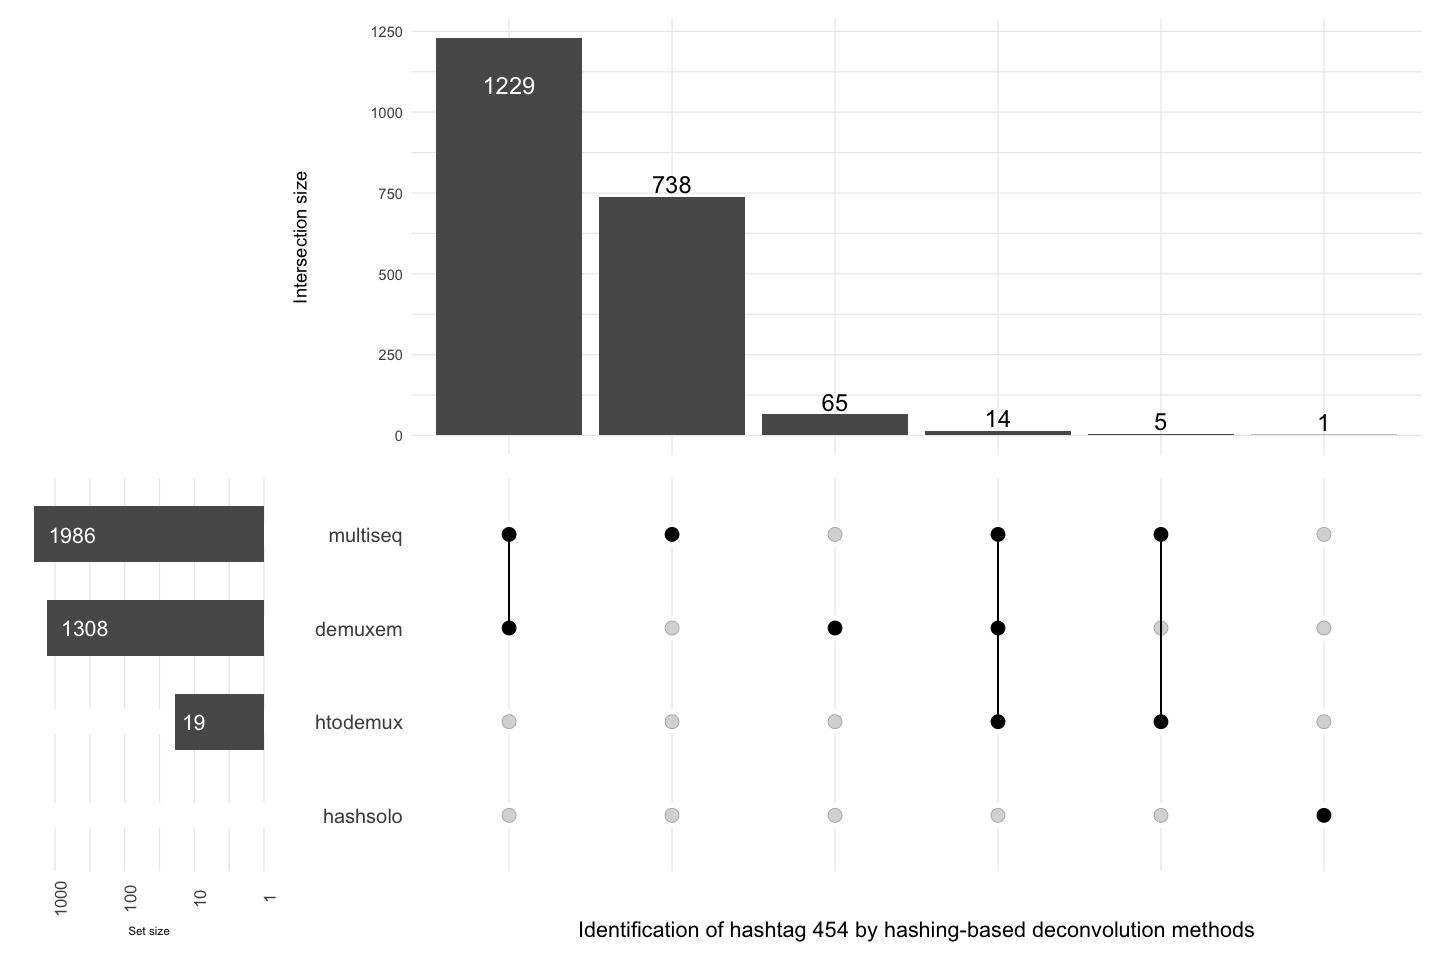

In [80]:
# convert to binary matrix
hash_ht454 <- convert2binary(hash_gx38_assign, 'Hash454')

ComplexUpset::upset(hash_ht454, colnames(hash_ht454), width_ratio = 0.2, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Identification of hashtag 454 by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=6), hjust = -0.3, 
                                                            stat = 'count', color = 'white', size = 4.5) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 7)) + 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=5))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

ggsave("S10-upset-hashing-hashtag454-gx38.png", width= 12, height=8, dpi=300)

Using 'variable' as value column. Use 'value.var' to override



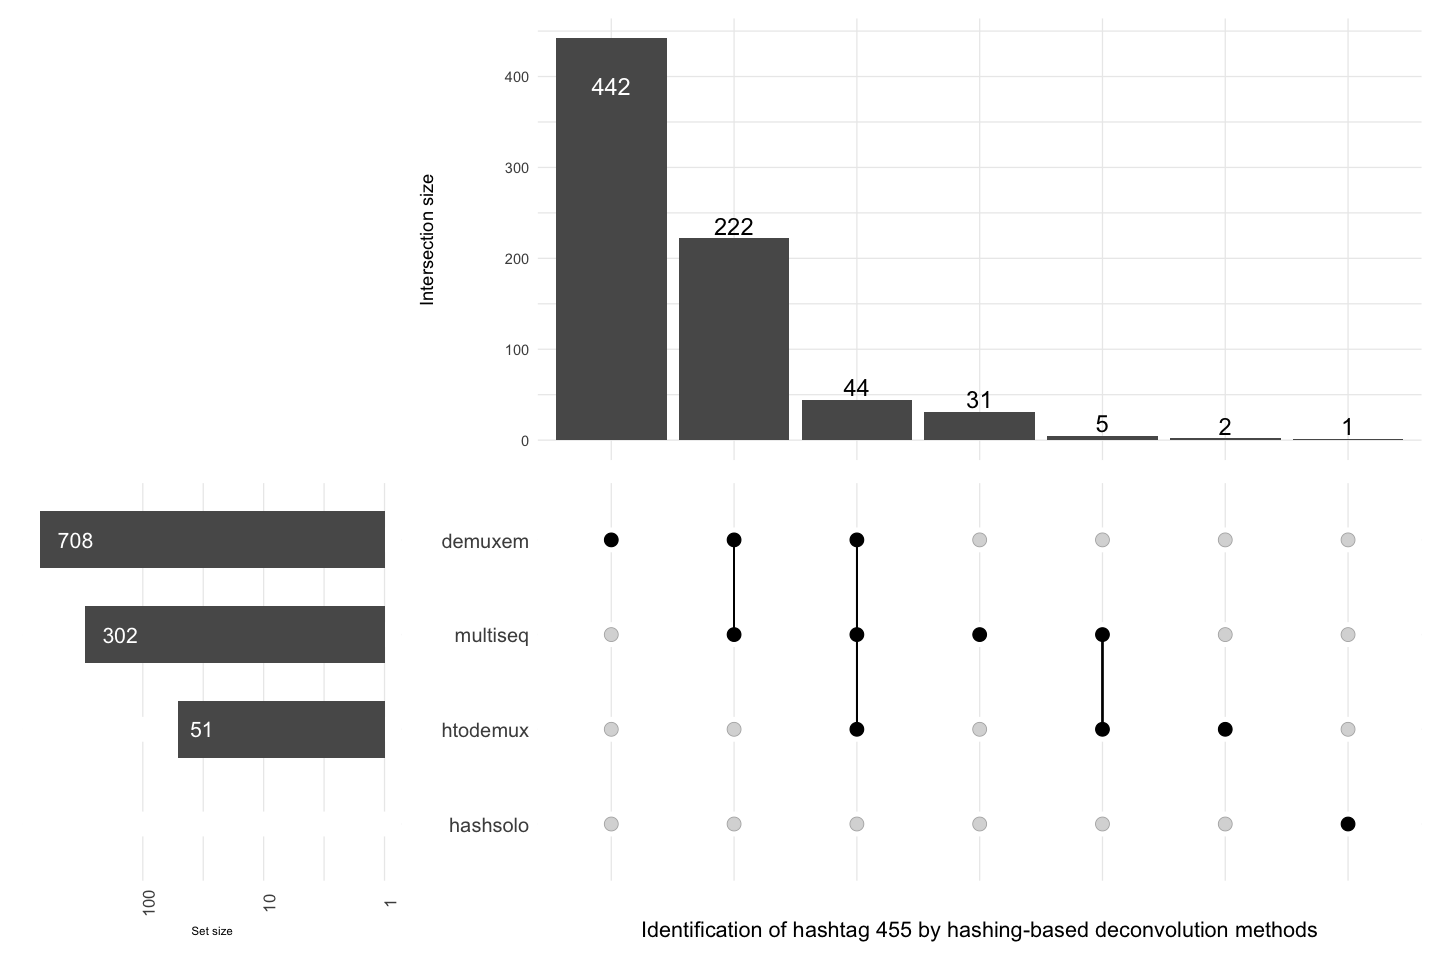

In [81]:
# convert to binary matrix
hash_ht455 <- convert2binary(hash_gx38_assign, 'Hash455')

ComplexUpset::upset(hash_ht455, colnames(hash_ht455), width_ratio = 0.3, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Identification of hashtag 455 by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=6), hjust = -0.5, 
                                                            stat = 'count', color = 'white', size = 4.5) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 7)) + 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=5))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))
# ggsave("S11-upset-hashing-hashtag455-gx38.png", width= 10, height=8, dpi=300)

Using 'variable' as value column. Use 'value.var' to override



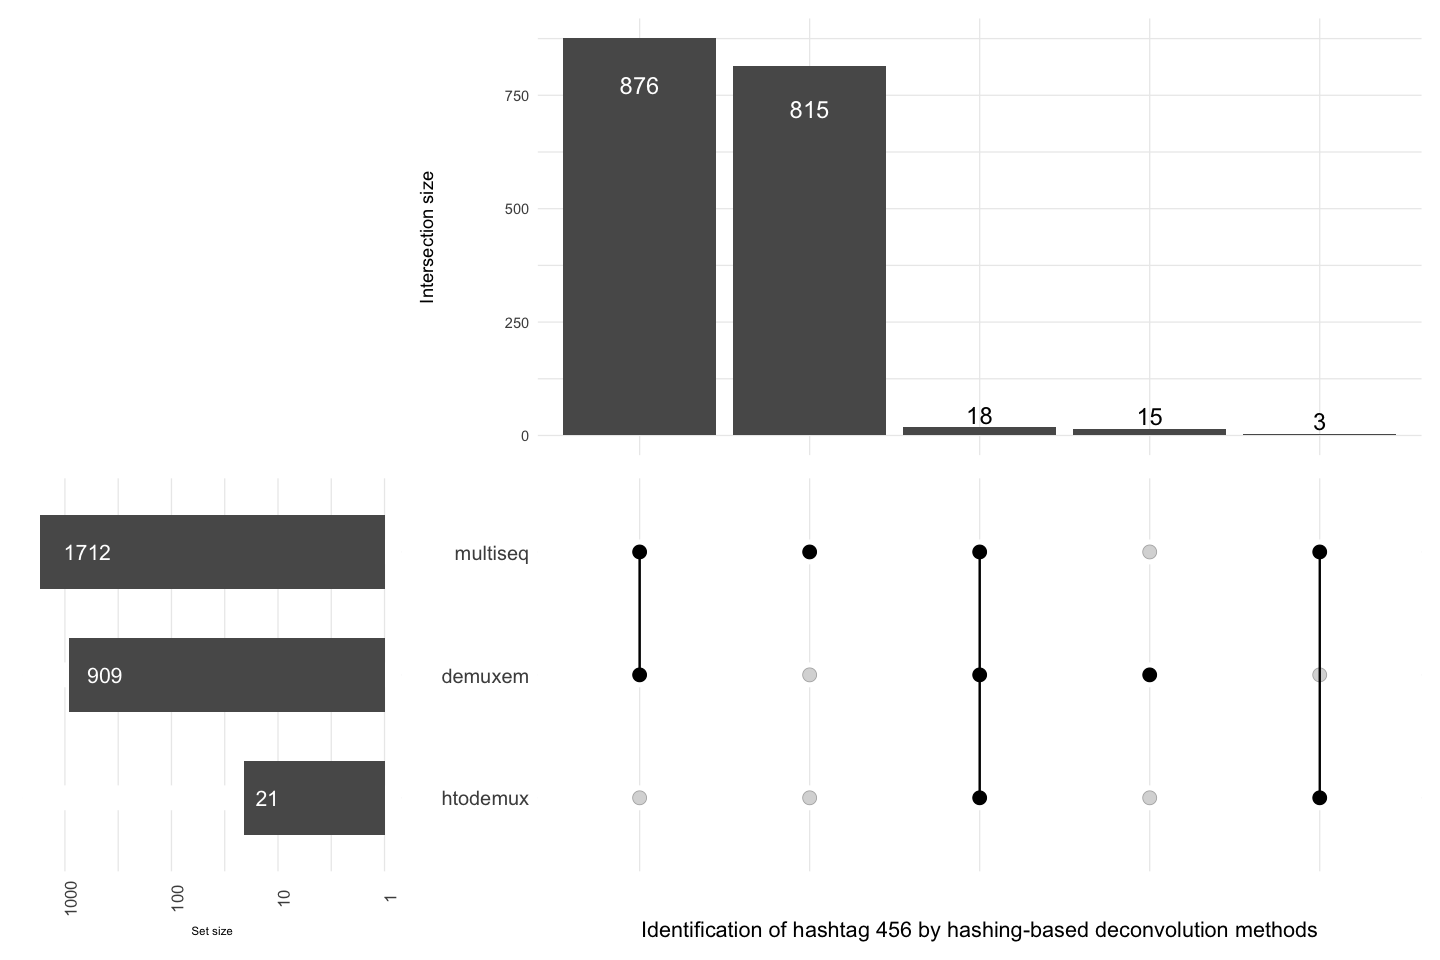

In [82]:
# convert to binary matrix
hash_ht456 <- convert2binary(hash_gx38_assign, 'Hash456')

ComplexUpset::upset(hash_ht456, colnames(hash_ht456), width_ratio = 0.3, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Identification of hashtag 456 by hashing-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=6), hjust = -0.5, 
                                                            stat = 'count', color = 'white', size = 4.5) +
                               theme(axis.text.x = element_text(angle = 90, size=10), text = element_text(size = 7)) + 
                               scale_y_continuous(trans=reverse_log_trans())),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=5))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

# ggsave("S12-upset-hashing-hashtag456-gx38.png", width= 10, height=8, dpi=300)

## Visualisation of imbalanced hashing deconvolution results

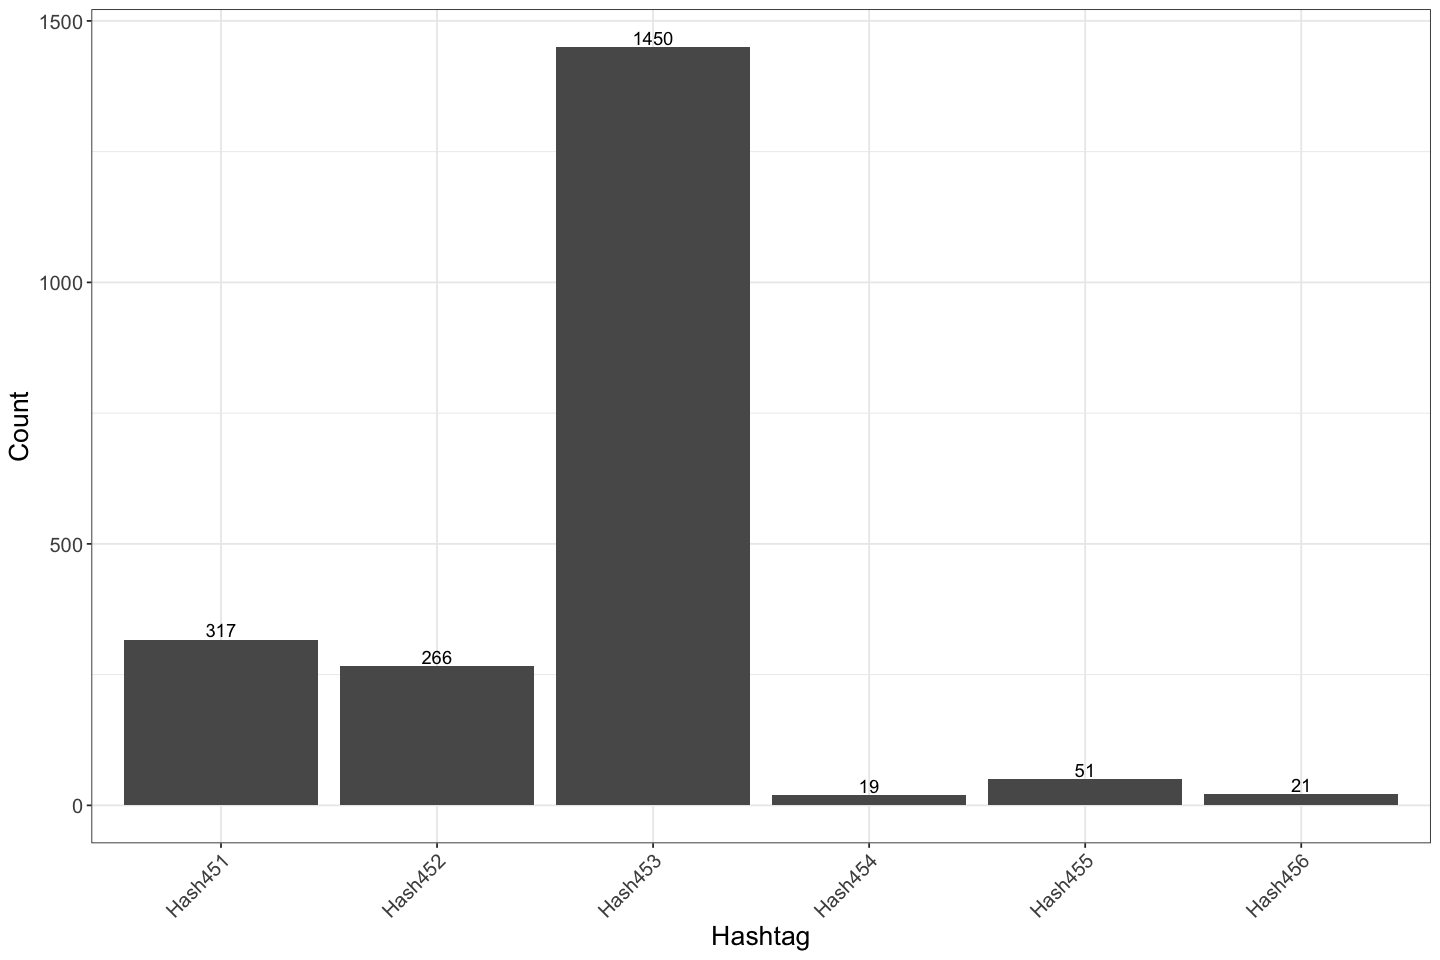

In [83]:
# Subset to htodemux result
htodemux_gx38_assign <- hash_gx38_assign[, c(1,4)]
htodemux_gx38_assign <- na.omit(htodemux_gx38_assign)

# Subset to singlets
htodemux_gx38_assign <- htodemux_gx38_assign[!htodemux_gx38_assign$htodemux %in% c('negative', 'doublet'),]

# Barplot
ggplot(htodemux_gx38_assign, aes(htodemux_gx38_assign$htodemux)) + geom_bar() + 
    geom_text(stat='count', aes(label=..count..), vjust=-0.2) + theme_bw() + ylab("Count") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1, size=12), axis.title.y = element_text(size=16), 
         axis.text.y = element_text(size=12), axis.title.x = element_text(size=16)) + xlab("Hashtag")

In [84]:
# Load genetic demultiplexing results
gene_gx38_classi <-fread("../data/pipeline_output/gx38/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx38_classi) <- gsub("_1", "", colnames(gene_gx38_classi))

## Visualisation of genetic deconvolution results

In [85]:
# Load genetic demultiplexing results
gene_gx38_classi <-fread("../data/pipeline_output/gx38/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx38_classi) <- gsub("_1", "", colnames(gene_gx38_classi))

# Reorder the result
summary_gene_gx38 <- melt(gene_gx38_classi, id.vars = "Barcode", variable.name = "Method", 
                          value.name = "Classification")
summary_gene_gx38 <- na.omit(summary_gene_gx38)
summary_gene_gx38 <- as.data.frame(table(summary_gene_gx38[,-1]))
colnames(summary_gene_gx38)[3] <- "Count" 
summary_gene_gx38 <- summary_gene_gx38[order(summary_gene_gx38$Classification, decreasing = T),]
head(summary_gene_gx38)

,Method,Classification,Count
,<fct>,<fct>,<int>
9,freemuxlet,singlet,11908
10,scsplit,singlet,10604
11,souporcell,singlet,11269
12,vireo,singlet,10351
5,freemuxlet,negative,17
6,scsplit,negative,0


Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."


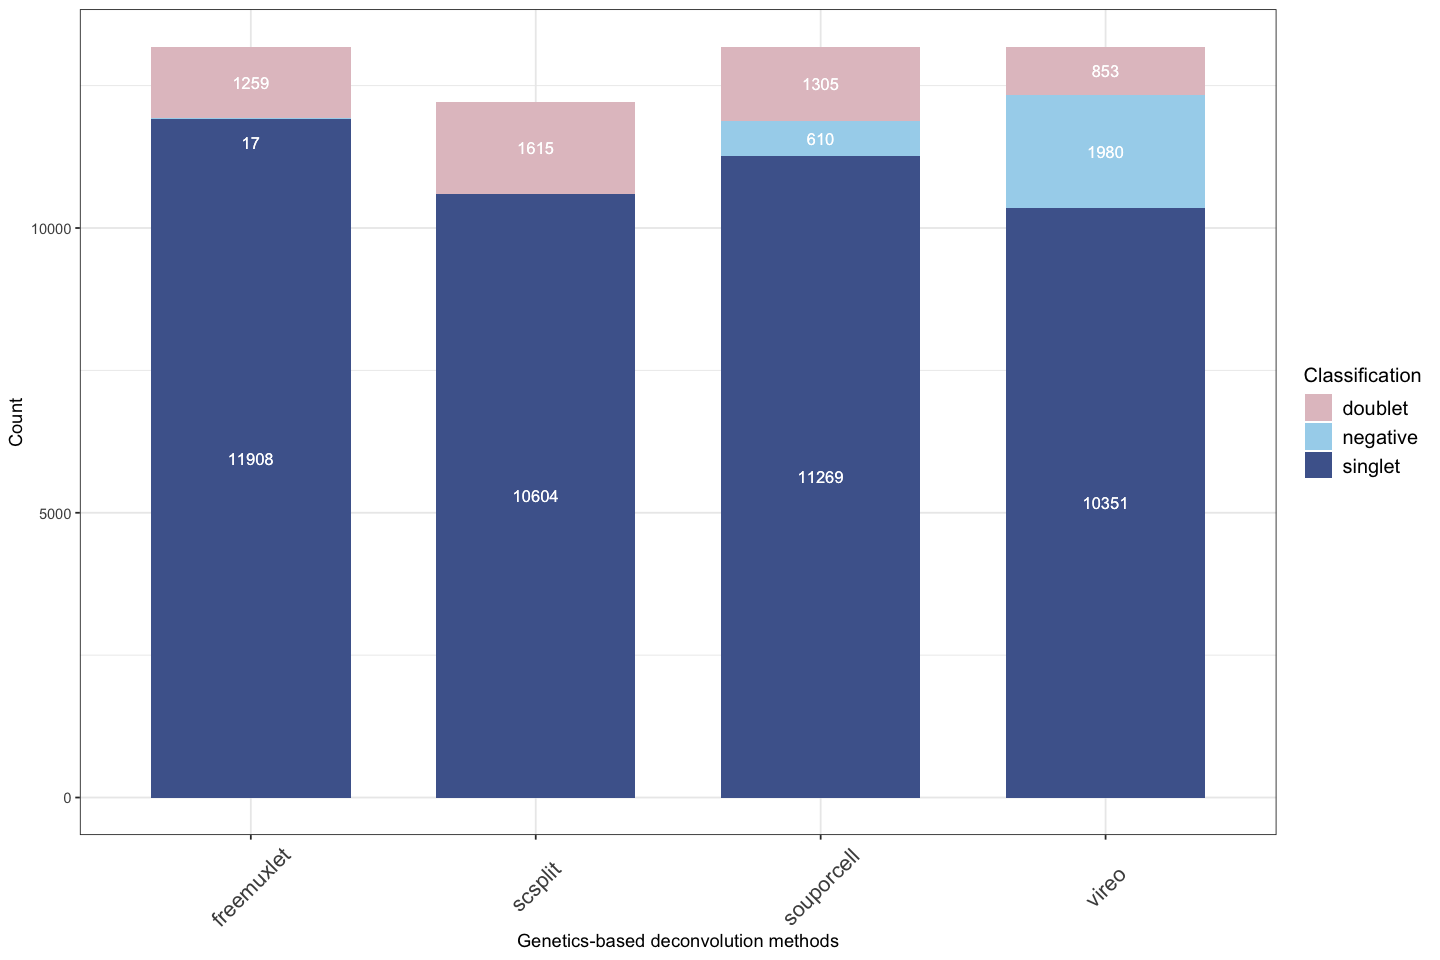

In [86]:
# Determine the y-axis position of labels ylab_pos
summary_gene_gx38_cumsum <- ddply(summary_gene_gx38, "Method", transform, 
                                  label_ypos=cumsum(Count)- 0.5*Count)

# Avoid showing count 0
summary_gene_gx38_cumsum[summary_gene_gx38_cumsum$Count==0,]$label_ypos <- NA

# Modify the ylab_pos manually
summary_gene_gx38_cumsum[summary_gene_gx38_cumsum$Method=="freemuxlet" & 
                         summary_gene_gx38_cumsum$Classification=="negative",]$label_ypos <- 11500

# Barplot
ggplot(summary_gene_gx38_cumsum, aes(x=Method, y=Count, fill=Classification)) + geom_bar(stat="identity", width=0.7) +
    scale_fill_manual(values = c("#E2C3C9", "#a6d5ed", "#4e659b")) + theme_bw() + 
    xlab("Genetics-based deconvolution methods") +
    geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=3.5) +
    geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=3.5) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, size = 13),
    legend.text=element_text(size=12),
    legend.title=element_text(size=12))

# ggsave("S13-gene-bar-gx38.png", dpi = 300, height = 5, width = 7)

## Upset plot for droplet classification of genetic deconvolution methods

In [87]:
genetic_gx38_classi_new_singlet <- convert2binary(gene_gx38_classi, 'singlet')
genetic_gx38_classi_new_doublet <- convert2binary(gene_gx38_classi, 'doublet')

Using 'variable' as value column. Use 'value.var' to override

Using 'variable' as value column. Use 'value.var' to override



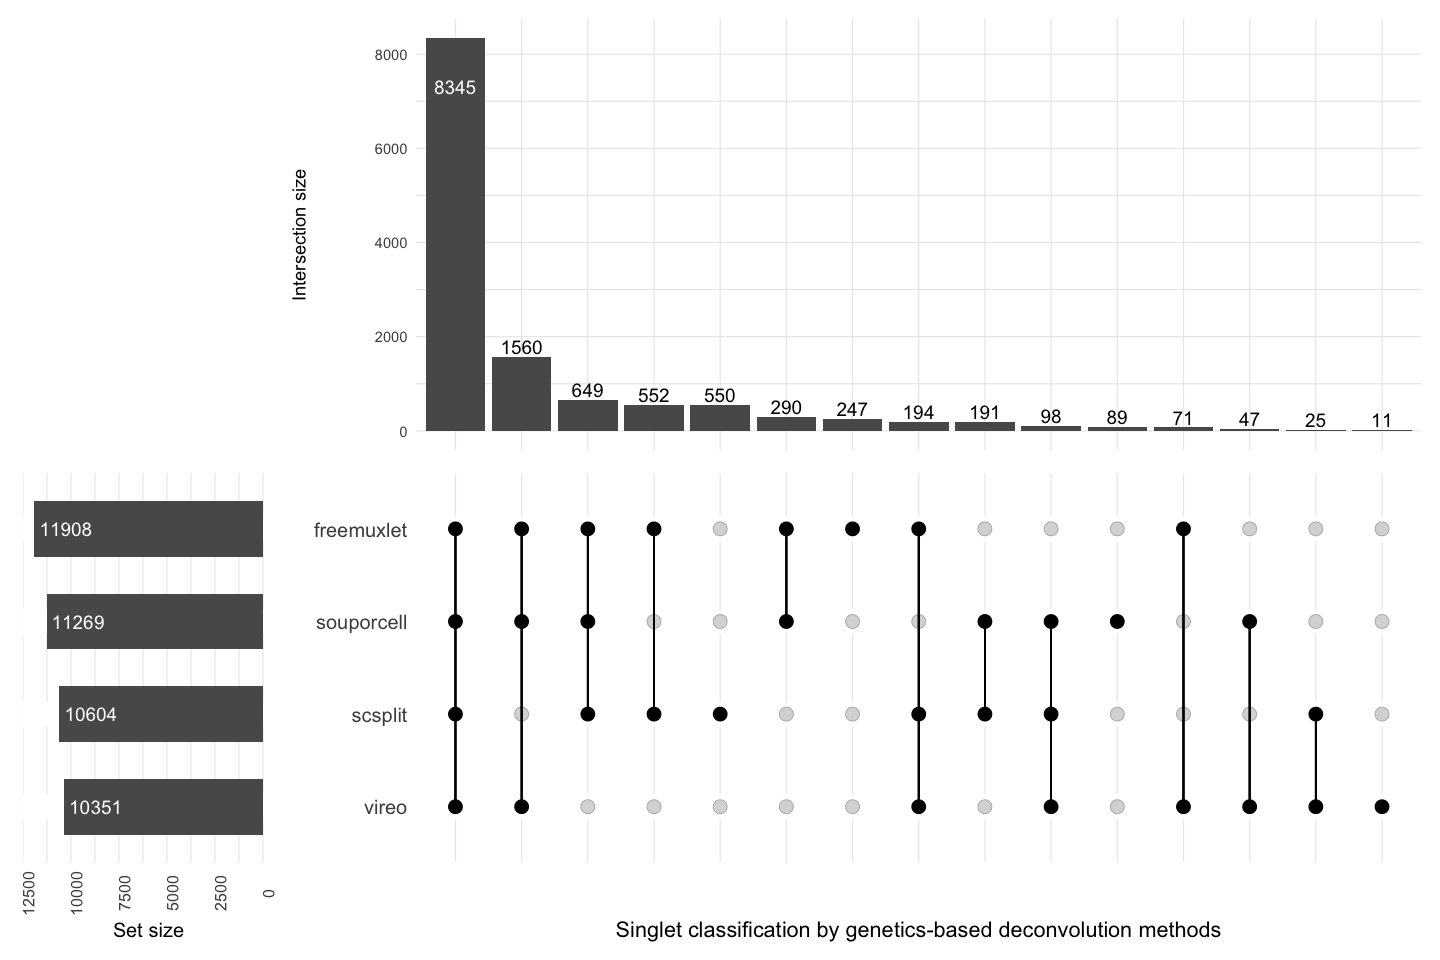

In [88]:
# Change plot size to 12 x 8
options(repr.plot.width=12, repr.plot.height=8)

ComplexUpset::upset(genetic_gx38_classi_new_singlet, colnames(genetic_gx38_classi_new_singlet), width_ratio = 0.2, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Singlet classification by genetics-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=3), hjust = -0.1, 
                                                            stat = 'count', color = 'white', size = 4) +
                               theme(axis.text.x = element_text(angle = 90), text = element_text(size = 12))),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=4))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

# ggsave("S14-upset-genetic-singlet-gx38.png", width= 12, height=8, dpi=300)

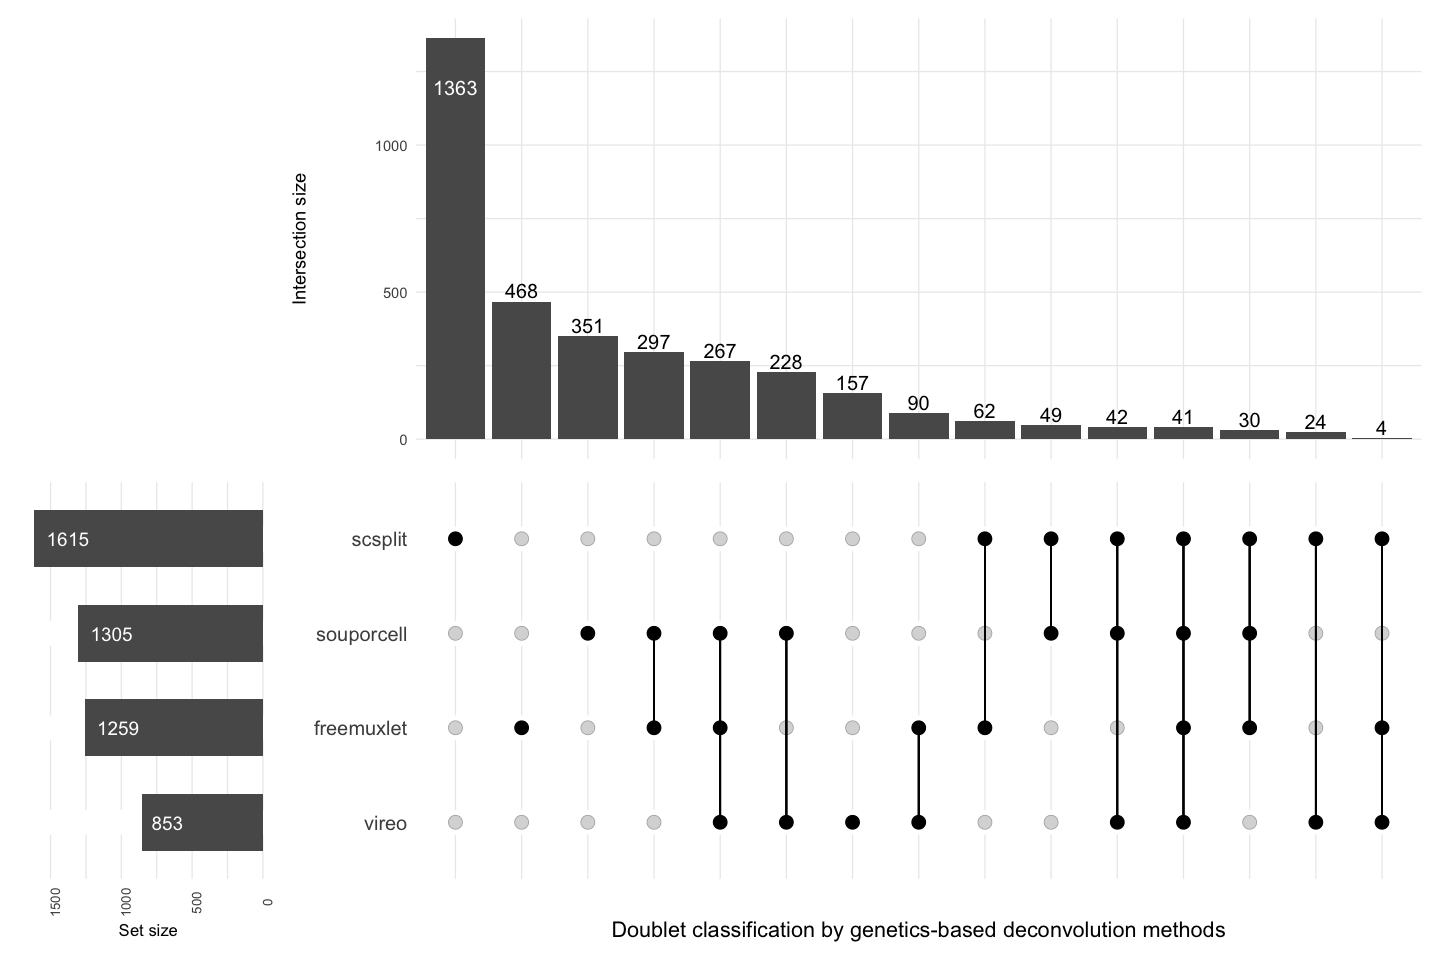

In [89]:
ComplexUpset::upset(genetic_gx38_classi_new_doublet, colnames(genetic_gx38_classi_new_doublet), width_ratio = 0.2, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Doublet classification by genetics-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count.., size=3), hjust = -0.3, 
                                                            stat = 'count', color = 'white', size = 4) +
                               theme(axis.text.x = element_text(angle = 90), text = element_text(size = 10))),
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=4.2))),
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=12),
                                                                                text=element_text(size=13)))))

# ggsave("S15-upset-genetic-doublet-gx38.png", width= 12, height=8, dpi=300)

## Visualisation of donor matching

In [90]:
# Load correlation matrix
correlation_gx38 <- fread("../data/pipeline_output/gx38/correlation_res.csv")
correlation_gx38 <- as.data.frame(correlation_gx38)
rownames(correlation_gx38) <- correlation_gx38$V1
correlation_gx38 <- correlation_gx38[,-1]
colnames(correlation_gx38) <- gsub("donor", "Donor-", colnames(correlation_gx38))
rownames(correlation_gx38) <- gsub("-TotalSeqA", "", rownames(correlation_gx38))

# Define the color palette and the annotation
newCols <- colorRampPalette(grDevices::rainbow(6))
annoCol <- newCols(6)
names(annoCol) <- colnames(correlation_gx38)
annoCol <- list(category = annoCol)

# Sort the axis
correlation_gx38 <- correlation_gx38[order(row.names(correlation_gx38)), ]

# Heatamp
pheatmap(correlation_gx38, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "white", fontsize = 12, cluster_rows = F, cluster_cols = F)
         # , filename="S16-concordance_heatmap_gx38.png", width = 7, height = 5)

In [91]:
# Load genetic demultiplexing results
gene_gx38_assign <-fread("../data/pipeline_output/gx38/genetic_assignment_all.csv")

# Remove the trial ID
colnames(gene_gx38_assign) <- gsub("_1", "", colnames(gene_gx38_assign))

# Remove the donor prefix in vireo column
gene_gx38_assign$vireo <- gsub("donor", "", gene_gx38_assign$vireo)

## Visualisation of concordance among genetic deconvolution methods through confusion matrix

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,1,4,2541,0,1,0
1,2,4,0,1,1,2374
2,1,1,0,1,2215,2
3,576,3,0,1,2,0
4,2,2,1,1058,0,1
5,467,1580,1,1,0,0


quartz_off_screen 
                3

quartz_off_screen 
                4

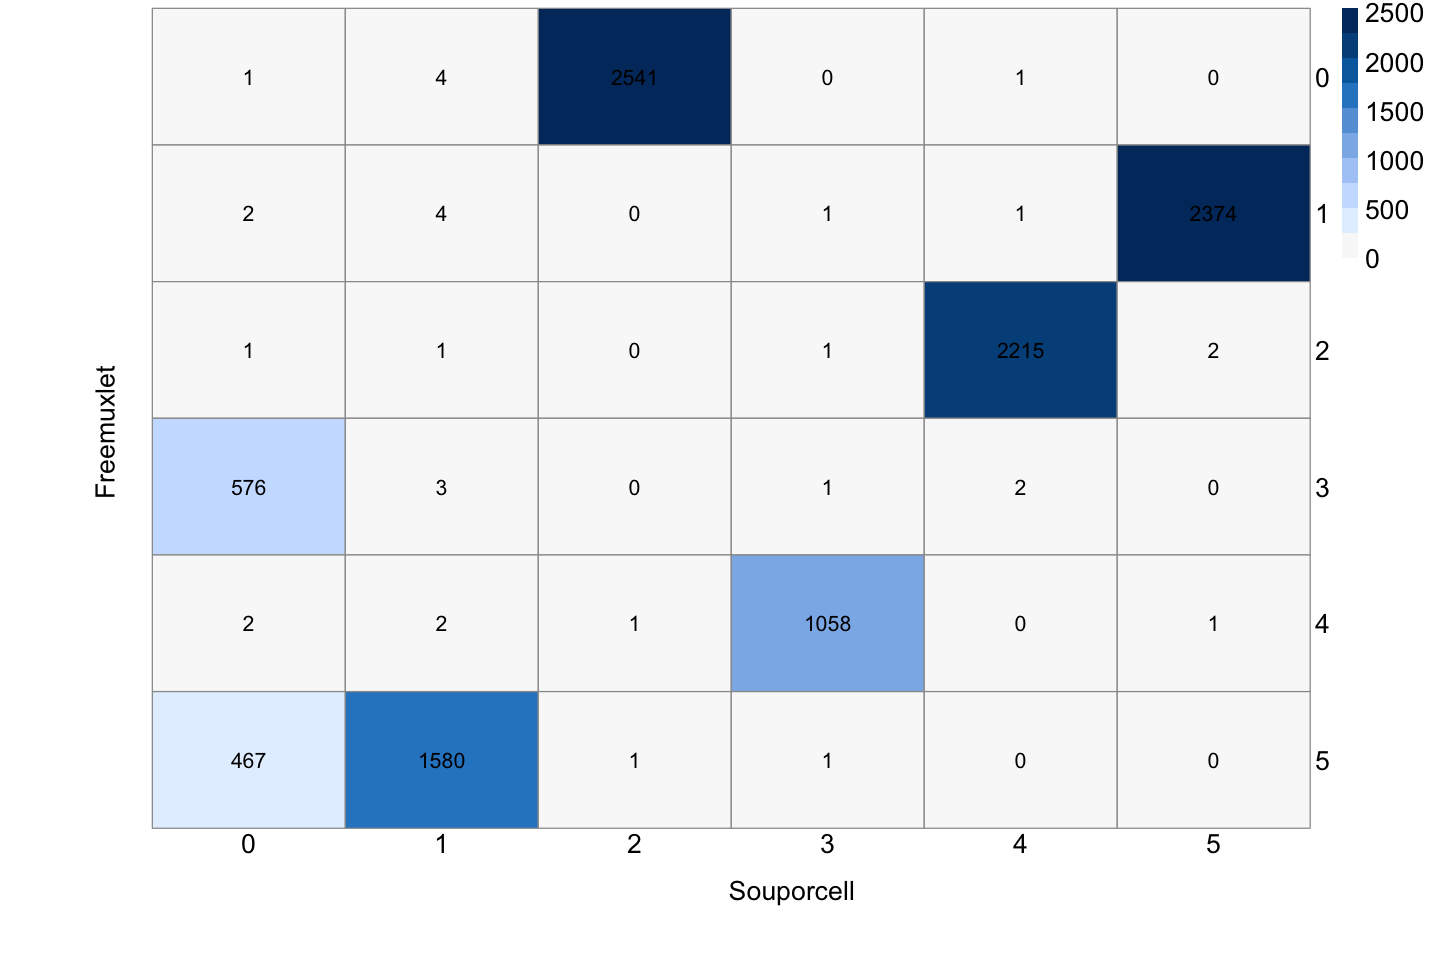

In [92]:
# Create an empyt matrix
confusion_matrix_f_so = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_f_so) = 0:5
colnames(confusion_matrix_f_so) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$freemuxlet == i & gene_gx38_assign$souporcell == j,])
    confusion_matrix_f_so[i+1,j+1] = row
  }
}

confusion_matrix_f_so

png("S17-heatmap-so-fr-gx38.png", res=300, width=11, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_f_so, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Souporcell", y=-0.03, gp=gpar(fontsize=16))
grid.text("Freemuxlet", x=-0.03, rot=90, gp=gpar(fontsize=16))

dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,2064,0
1,245,1520,0,0,0,0
2,549,0,0,0,0,0
3,0,0,2476,0,0,0
4,0,0,0,1006,1,0
5,0,0,0,1,1,2187


quartz_off_screen 
                3

quartz_off_screen 
                4

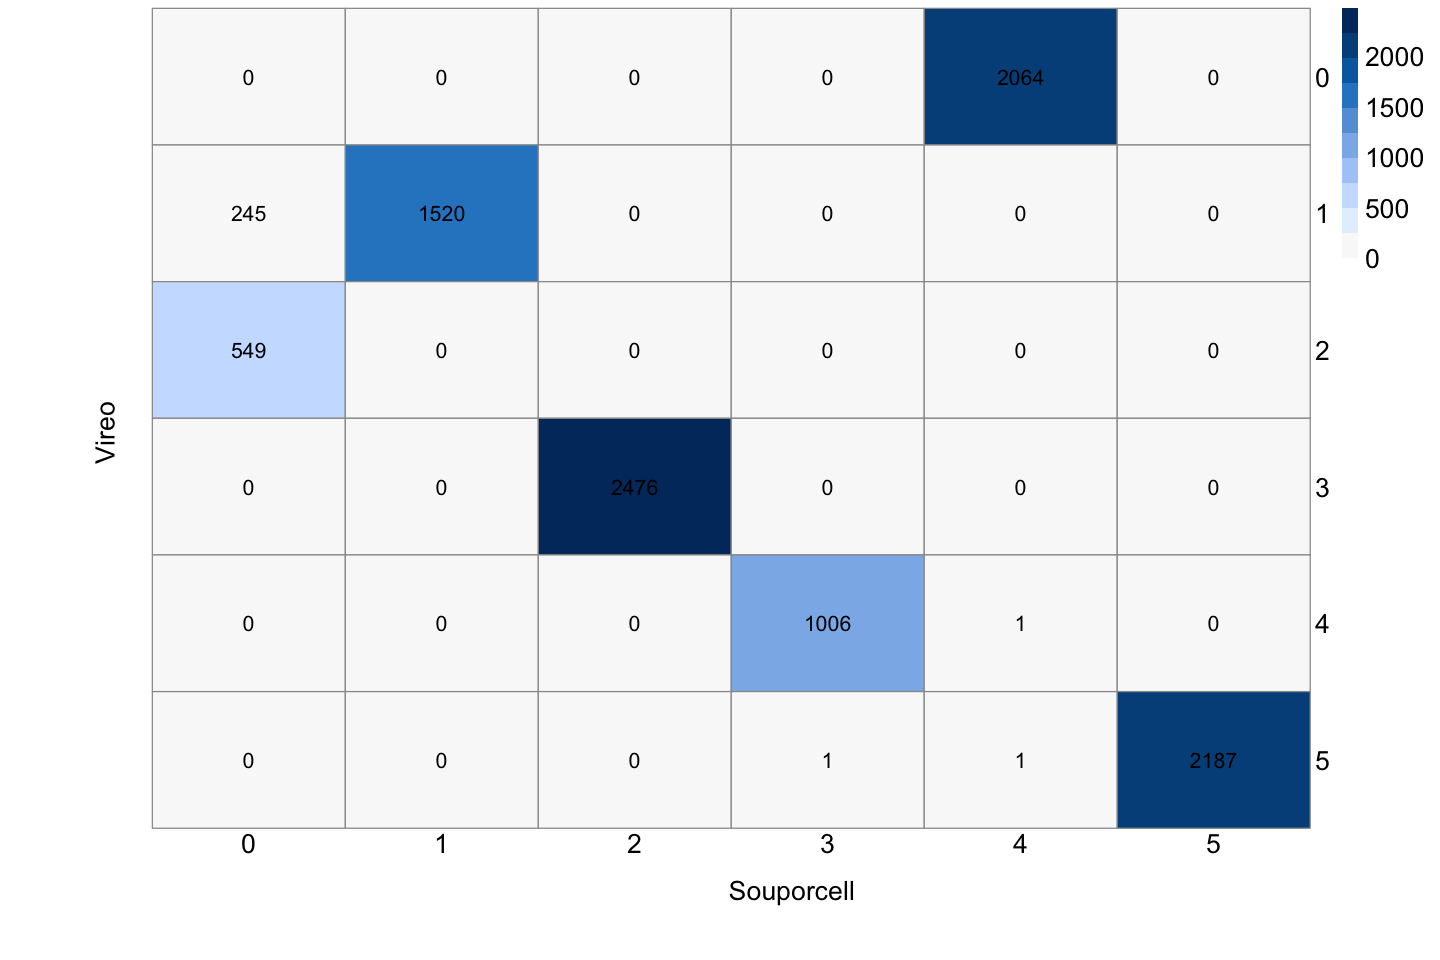

In [93]:
# Create an empyt matrix
confusion_matrix_v_so = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_so) = 0:5
colnames(confusion_matrix_v_so) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$vireo == i & gene_gx38_assign$souporcell == j,])
    confusion_matrix_v_so[i+1,j+1] = row
  }
}

confusion_matrix_v_so

png("S18-heatmap-so-v-gx38.png", res=300, width=11, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_so, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Souporcell", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))

dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,0,1,2048,0,0,0
1,2,0,2,0,0,1738
2,0,3,1,679,0,5
3,2509,0,0,0,1,0
4,0,0,0,1,994,1
5,0,2181,2,0,0,2


quartz_off_screen 
                3

quartz_off_screen 
                4

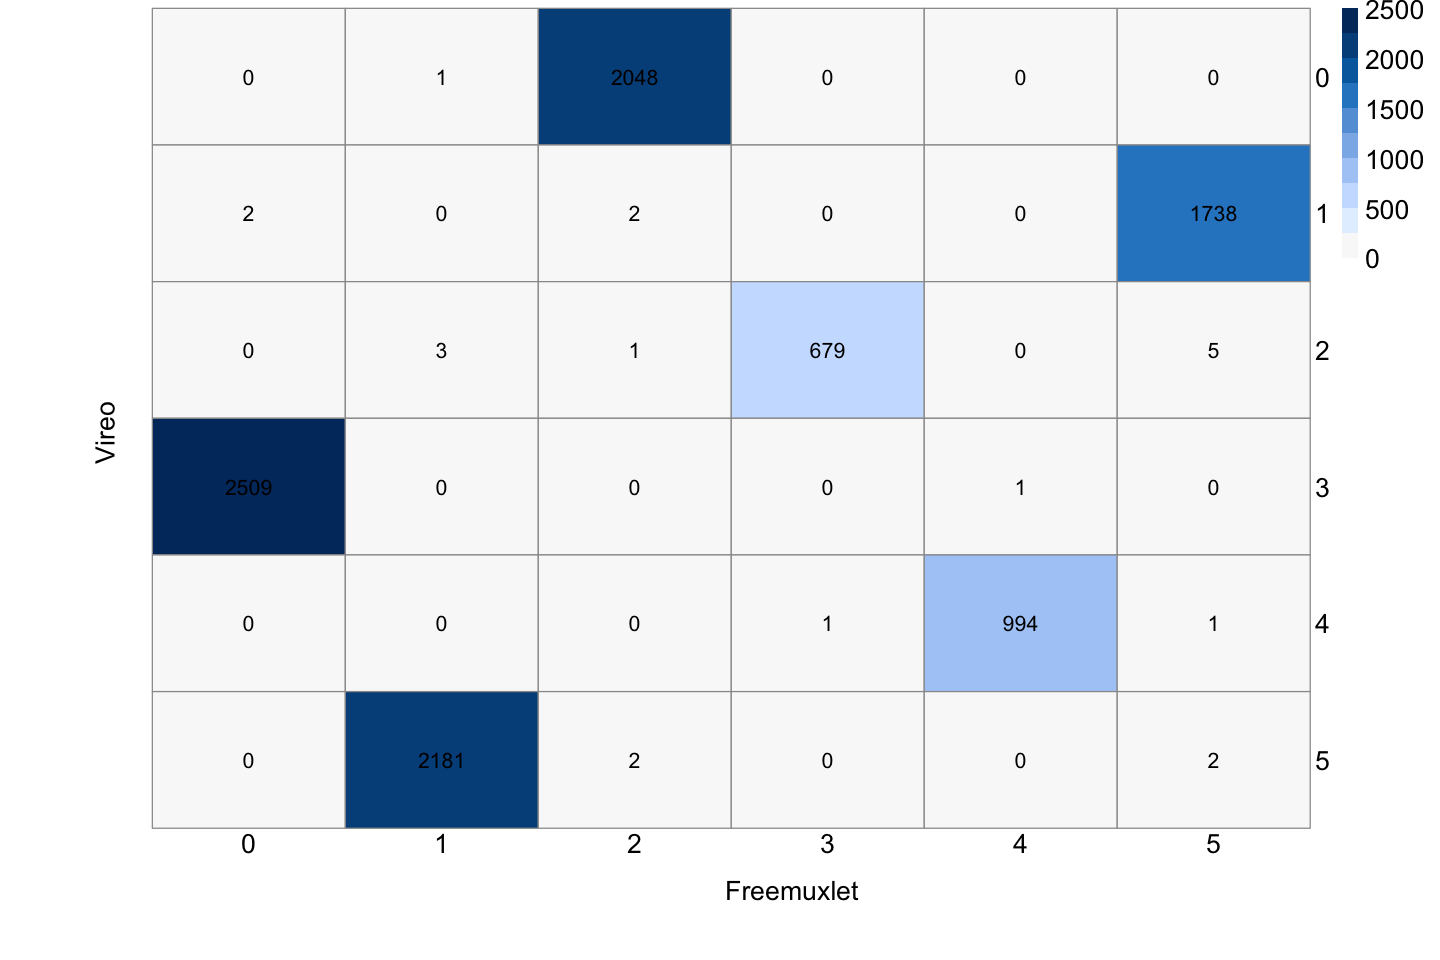

In [94]:
# Create an empyt matrix
confusion_matrix_v_fr = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_fr) = 0:5
colnames(confusion_matrix_v_fr) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$vireo == i & gene_gx38_assign$freemuxlet == j,])
    confusion_matrix_v_fr[i+1,j+1] = row
  }
}

confusion_matrix_v_fr

png("S19-heatmap-fr-v-gx38.png", res=300, width=11, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_fr, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Freemuxlet", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))

dev.copy()
dev.off()

,0,1,2,4,5,6
,<int>,<int>,<int>,<int>,<int>,<int>
0,163,222,172,2,776,474
1,166,313,253,1,307,237
2,62,134,97,0,193,84
3,258,17,28,2178,12,5
4,61,81,204,2,134,189
5,179,335,508,2,414,399


quartz_off_screen 
                3

quartz_off_screen 
                4

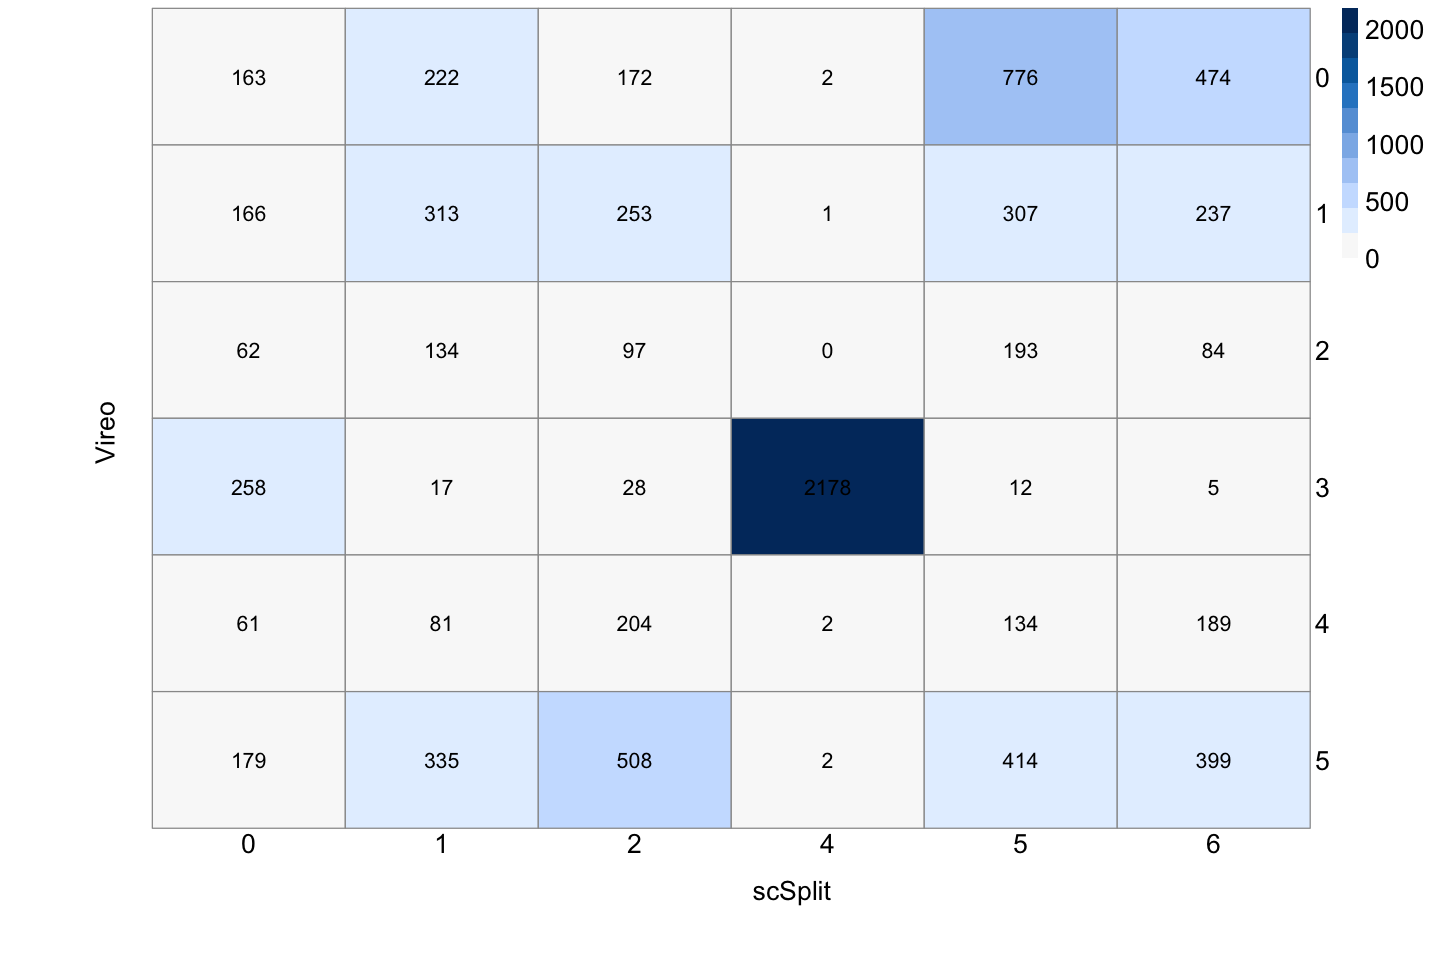

In [95]:
# Create an empyt matrix
confusion_matrix_v_sc = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_sc) = 0:5

# scSplit assigned doublets to cluster 4
donor_list <- c(0:2, 4:6)
colnames(confusion_matrix_v_sc) = donor_list

for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx38_assign[gene_gx38_assign$vireo == i & 
                                gene_gx38_assign$scsplit == donor_list[j+1],])
    confusion_matrix_v_sc[i+1,j+1] = row
  }
}

confusion_matrix_v_sc

png("S20-heatmap-v-sc-gx38.png", res=300, width=11, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_sc, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("scSplit", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()


## Visualisation of concordance between genetic and hashing deconvolution methods through confusion matrix

In [96]:
# Load the genetic and hashing result for comparison
hash_gene_result <- fread("../data/pipeline_output/gx38/assignment_all_genetic_and_hash.csv")

# Remove the trial ID
colnames(hash_gene_result) <- gsub("_1", "", colnames(hash_gene_result))

# Rename the donor id of vireo 
hash_gene_result$vireo <- gsub("donor", "", hash_gene_result$vireo)

# Rename the hashtag names of hashing methods
hash_gene_result$htodemux <- gsub("-TotalSeqA", "", hash_gene_result$htodemux)
hash_gene_result$multiseq <- gsub("-TotalSeqA", "", hash_gene_result$multiseq)
hash_gene_result$demuxem <- gsub("_TotalSeqA", "", hash_gene_result$demuxem)
hash_gene_result$hashsolo <- gsub("_TotalSeqA", "", hash_gene_result$hashsolo)

# Subset by only those cells detected by RNA
hash_gene_result <- hash_gene_result[Barcode %in% white_list_gx38,]

head(hash_gene_result)

Barcode,freemuxlet,scsplit,souporcell,vireo,demuxem,hashsolo,htodemux,multiseq
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TCATGAGTCACCACAA-1,2,doublet,4,0,doublet,doublet,Hash453,Hash454
ACTTATCCATTCCTCG-1,0,1,doublet,doublet,Hash451,doublet,negative,Hash451
ATAGAGACAACAACAA-1,0,4,2,3,negative,doublet,negative,Hash456
GTAAGTCTCTTCACAT-1,0,4,2,3,Hash452,Hash453,negative,Hash452
TCGAAGTTCAAACGTC-1,1,2,5,5,doublet,Hash453,Hash453,doublet
GTCATCCAGGCTCACC-1,1,2,5,5,doublet,doublet,doublet,doublet


,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
0,25,48,23,856,40,30
1,23,49,18,54,412,39
2,255,15,6,14,9,12
3,31,88,765,54,54,40
4,7,436,8,28,17,11
5,34,66,22,73,37,642


quartz_off_screen 
                3

quartz_off_screen 
                4

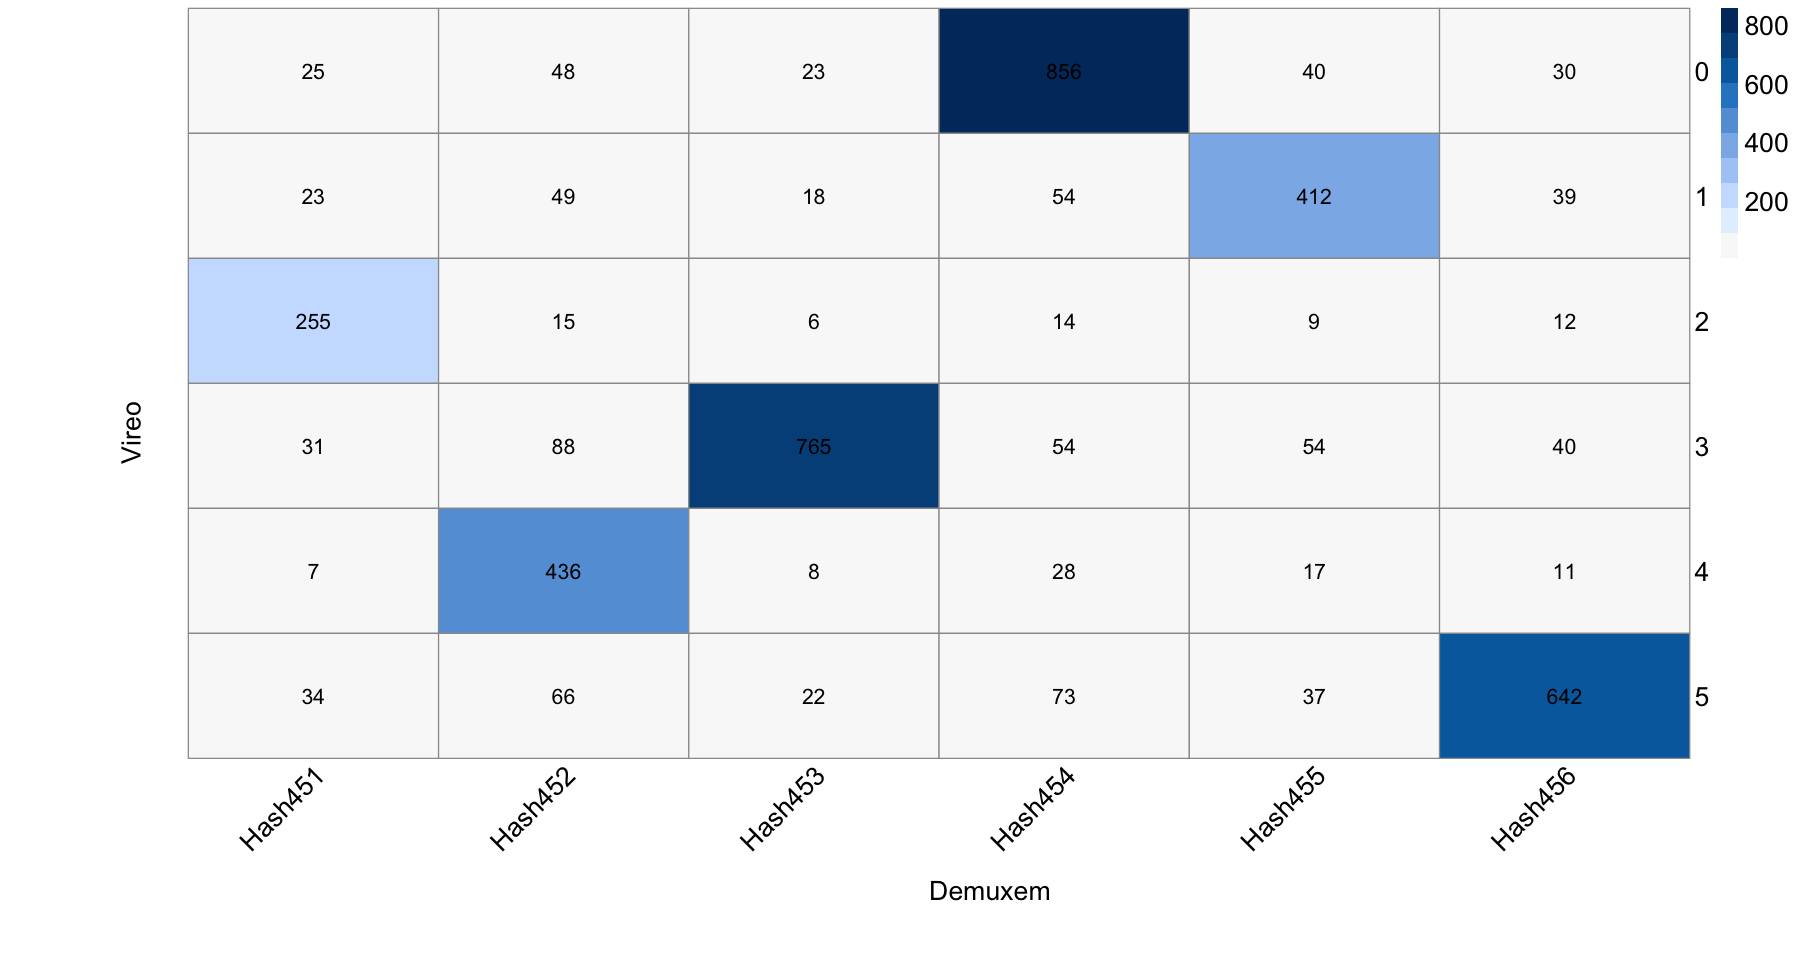

In [97]:
# Create an empyt matrix
confusion_matrix_v_demuxem = as.data.frame(matrix(ncol = 6, nrow = 6))
donor_list = paste0("Hash45",1:6)
donor_list_vireo = 0:5
rownames(confusion_matrix_v_demuxem) = donor_list_vireo
colnames(confusion_matrix_v_demuxem) = donor_list

for (i in c(0:5)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[i+1] &
                                  hash_gene_result$demuxem == donor_list[j],])
    confusion_matrix_v_demuxem[i+1, j] = row
  }
}

confusion_matrix_v_demuxem

png("S21-heatmap-v-demuxem-gx38.png", res=300, width=15, height=11, units="in")

# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_demuxem, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Demuxem", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()

,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
0,58,67,44,1165,12,74
1,109,107,63,139,218,124
2,340,20,13,34,1,26
3,96,127,986,121,14,120
4,32,502,23,50,3,45
5,103,99,59,134,5,1009


quartz_off_screen 
                3

quartz_off_screen 
                4

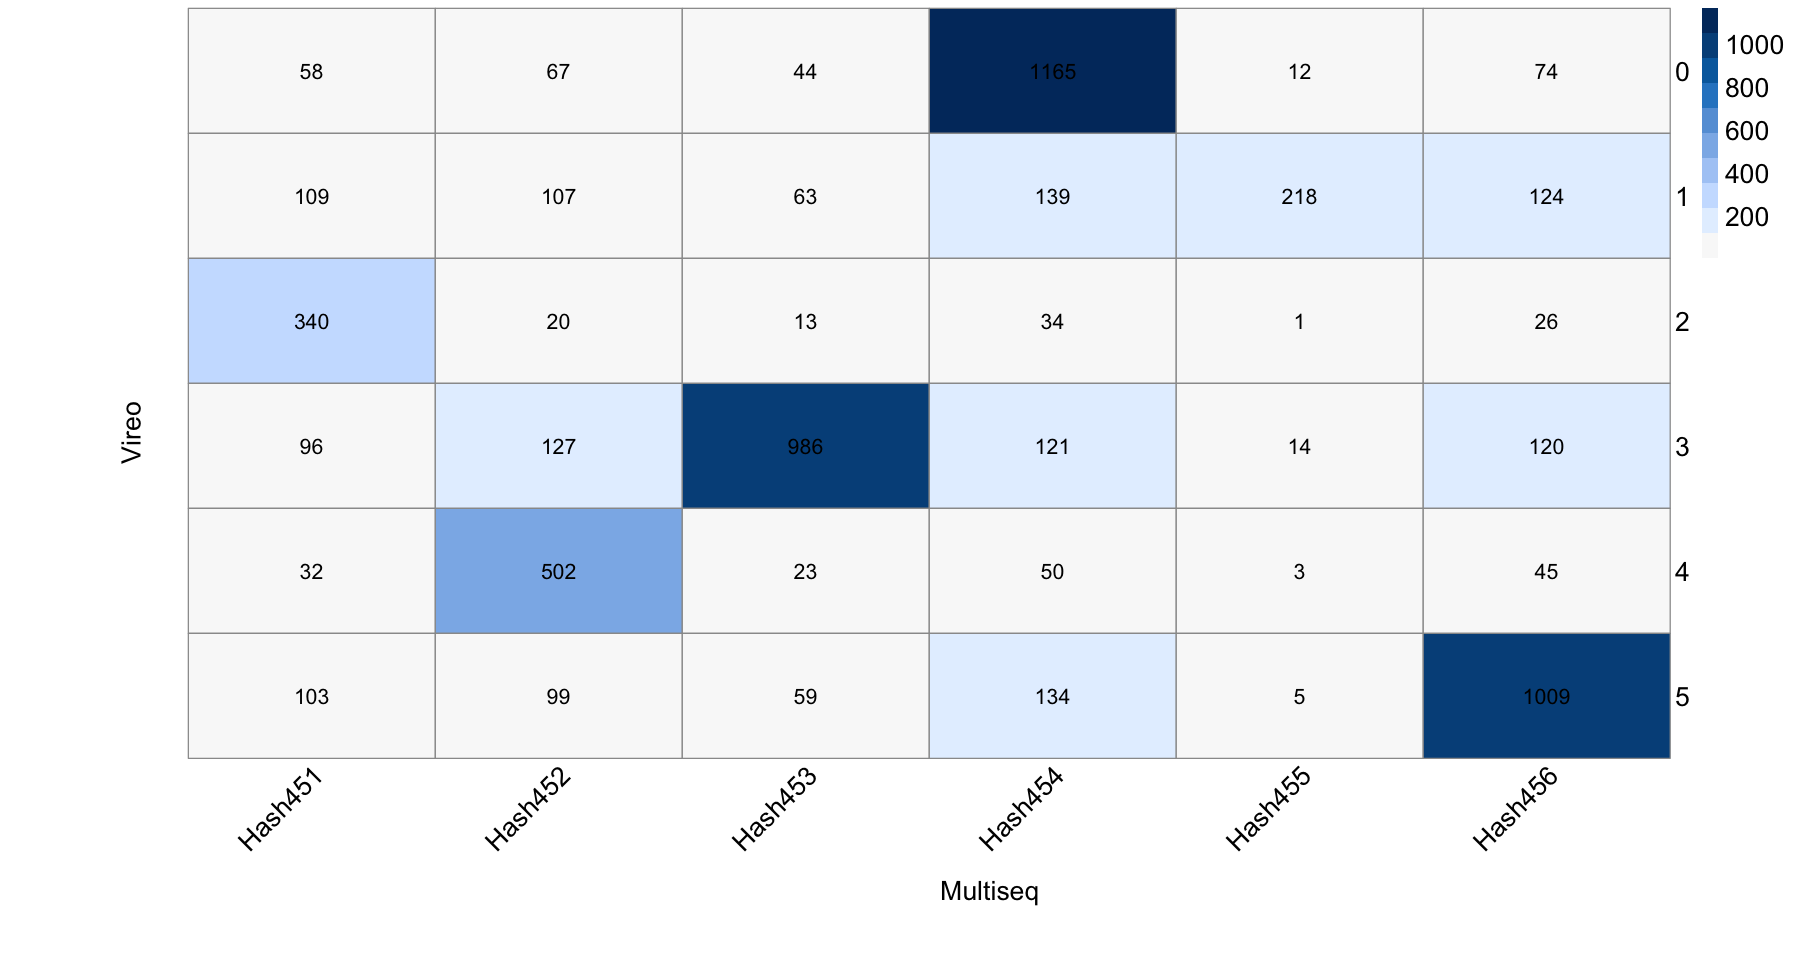

In [98]:
# Create an empyt matrix

confusion_matrix_v_multiseq = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_multiseq) = donor_list_vireo
colnames(confusion_matrix_v_multiseq) = donor_list

for (i in c(0:5)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[i+1] &
                                  hash_gene_result$multiseq == donor_list[j],])
    confusion_matrix_v_multiseq[i+1, j] = row
  }
}

confusion_matrix_v_multiseq

png("S22-heatmap-v-multiseq-gx38.png", res=300, width=15, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_multiseq, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Multiseq", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()

,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
0,36,5,401,15,8,2
1,19,7,177,0,21,2
2,139,2,5,1,0,0
3,14,9,379,1,5,2
4,3,197,35,0,2,1
5,43,4,277,0,3,11


quartz_off_screen 
                3

quartz_off_screen 
                4

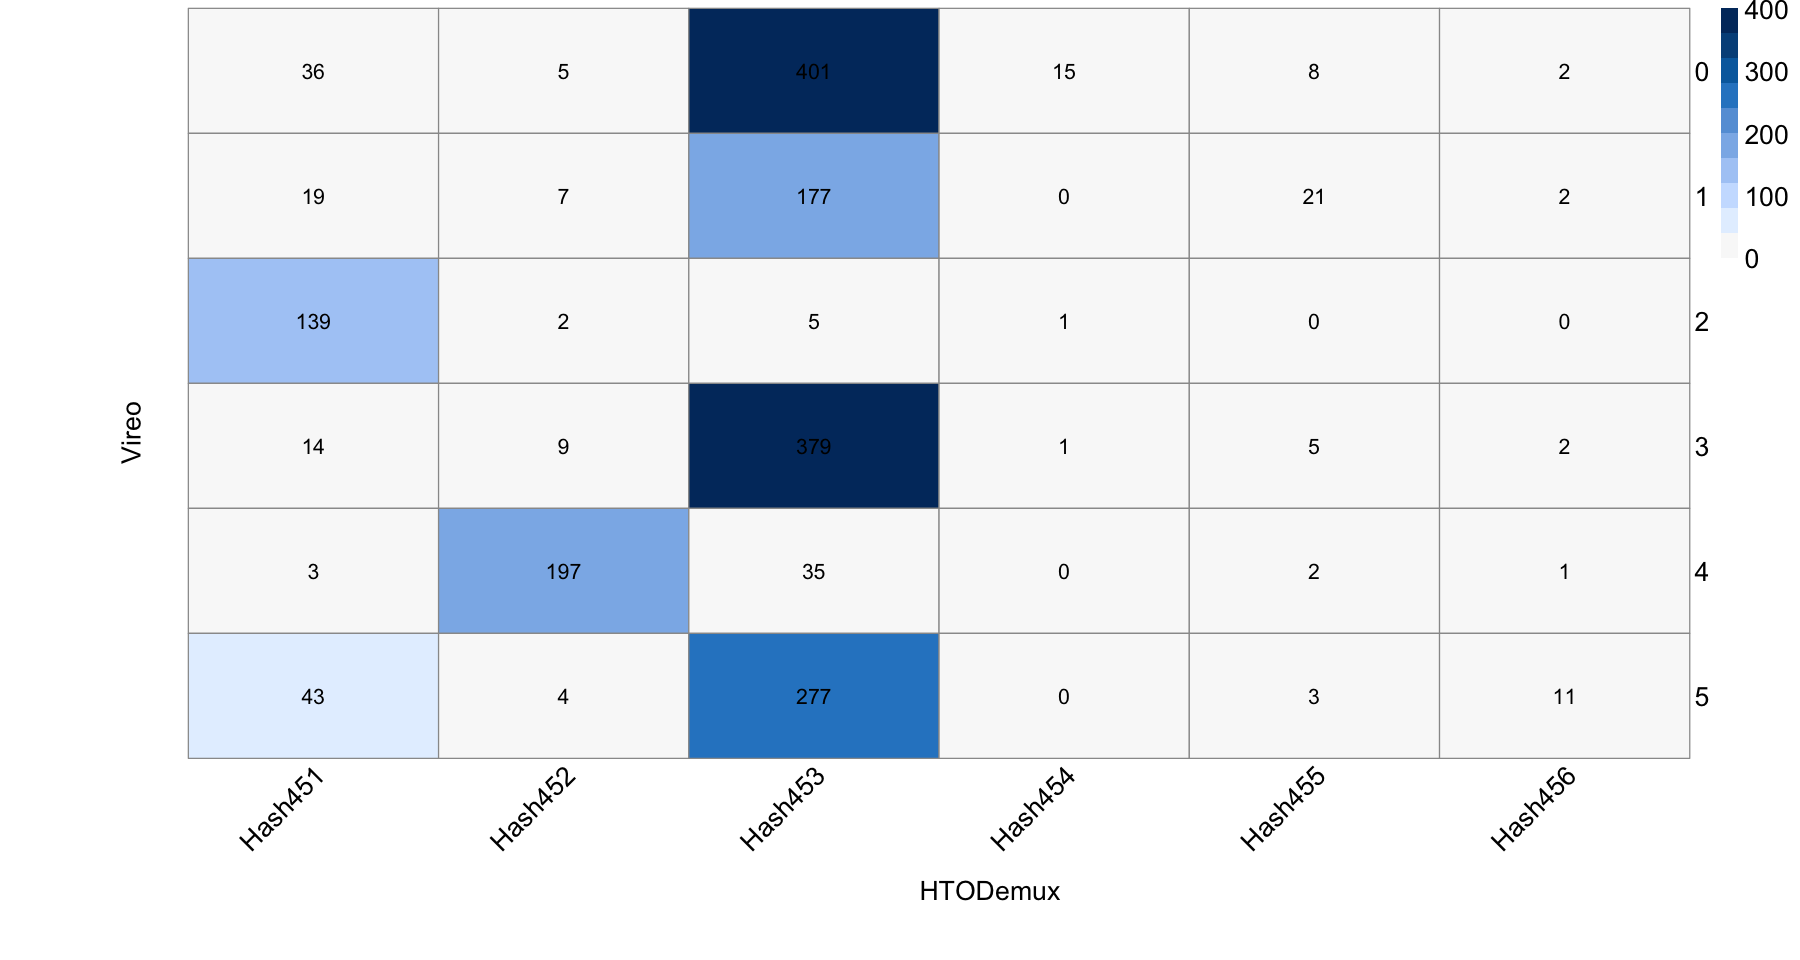

In [99]:
confusion_matrix_v_htodemux = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_htodemux) = donor_list_vireo
colnames(confusion_matrix_v_htodemux) = donor_list

for (i in c(0:5)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[i+1] &
                                  hash_gene_result$htodemux == donor_list[j],])
    confusion_matrix_v_htodemux[i+1, j] = row
  }
}

confusion_matrix_v_htodemux

png("S23-heatmap-v-htodemux-gx38.png", res=300, width=15, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_htodemux, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("HTODemux", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))

dev.copy()
dev.off()

,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
0,1,0,128,0,0,0
1,20,3,132,1,0,0
2,4,0,7,0,0,0
3,0,1,144,0,0,0
4,5,2,211,0,0,0
5,4,0,135,0,0,0


quartz_off_screen 
                3

quartz_off_screen 
                4

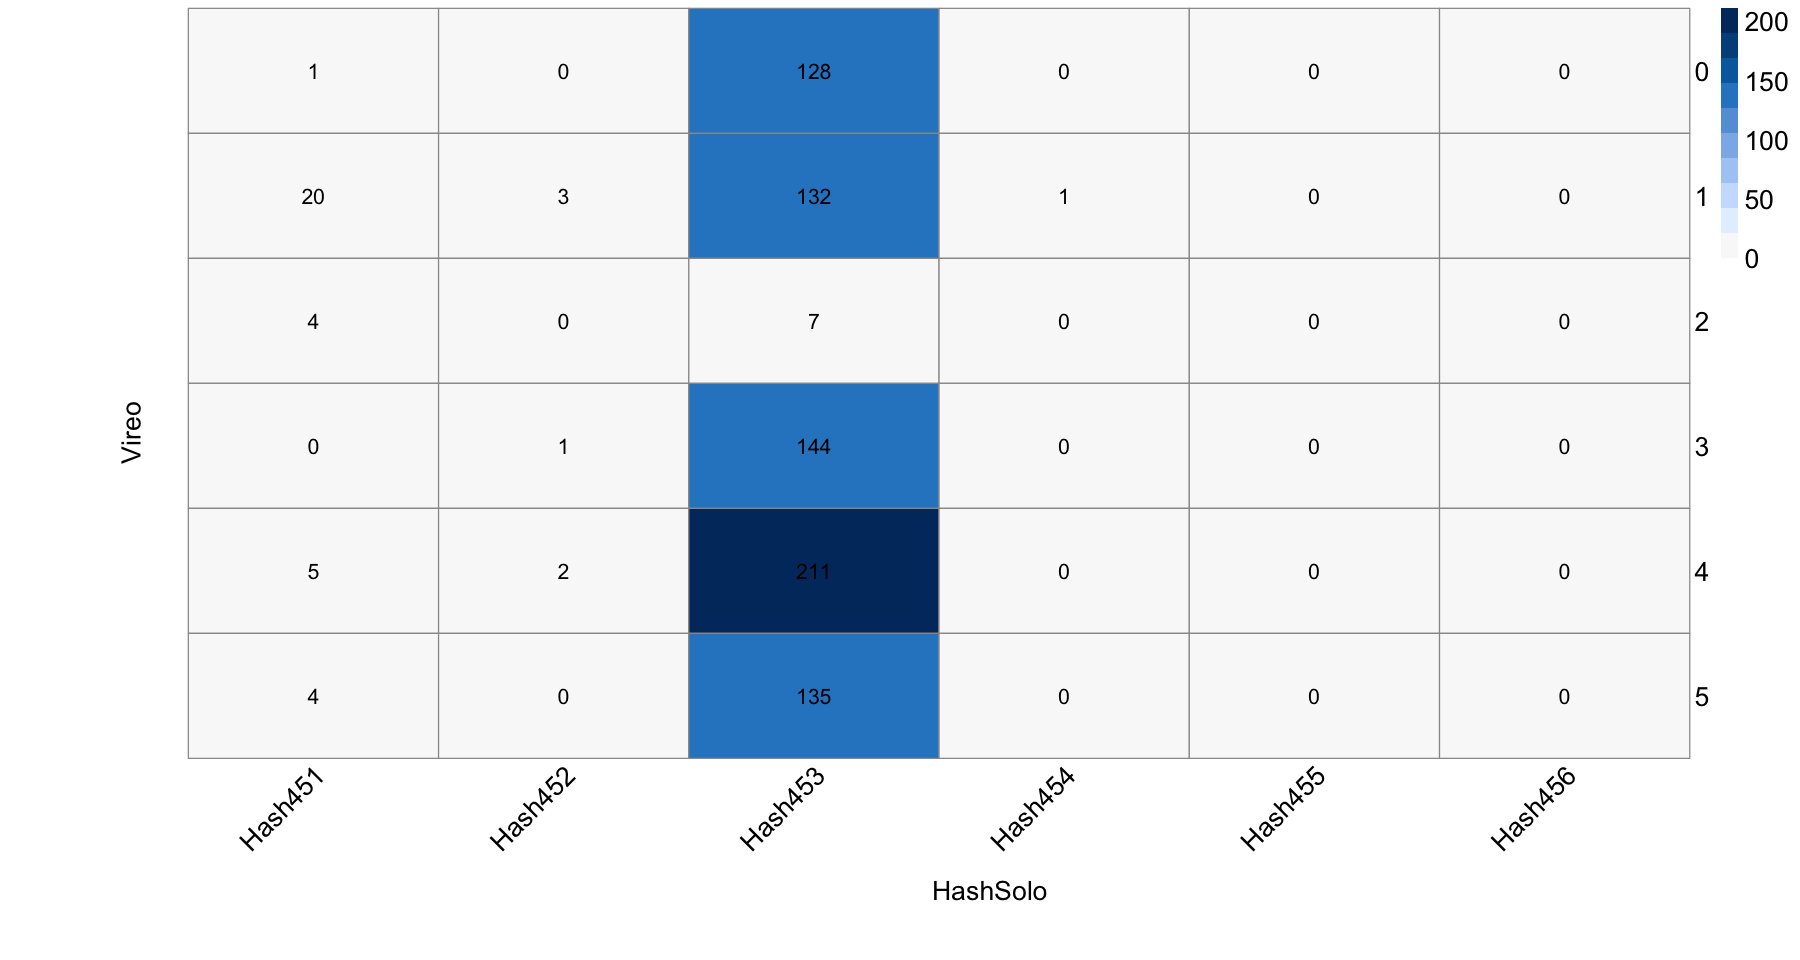

In [100]:
confusion_matrix_v_hashsolo = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_hashsolo) = donor_list_vireo
colnames(confusion_matrix_v_hashsolo) = donor_list

for (i in c(0:5)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$vireo == donor_list_vireo[i+1] &
                                  hash_gene_result$hashsolo == donor_list[j],])
    confusion_matrix_v_hashsolo[i+1, j] = row
  }
}

confusion_matrix_v_hashsolo

png("S24-heatmap-v-hashsolo-gx38.png", res=300, width=15, height=11, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_hashsolo, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("HashSolo", y=-0.03, gp=gpar(fontsize=16))
grid.text("Vireo", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()

## Visualisation of concordance among hashing deconvolution methods through confusion matrix

,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,432,0,0,0,0,0
Hash452,0,806,0,0,0,0
Hash453,0,0,853,0,0,0
Hash454,0,0,0,1243,0,0
Hash455,11,6,4,10,266,13
Hash456,0,0,0,0,0,894


quartz_off_screen 
                3

quartz_off_screen 
                4

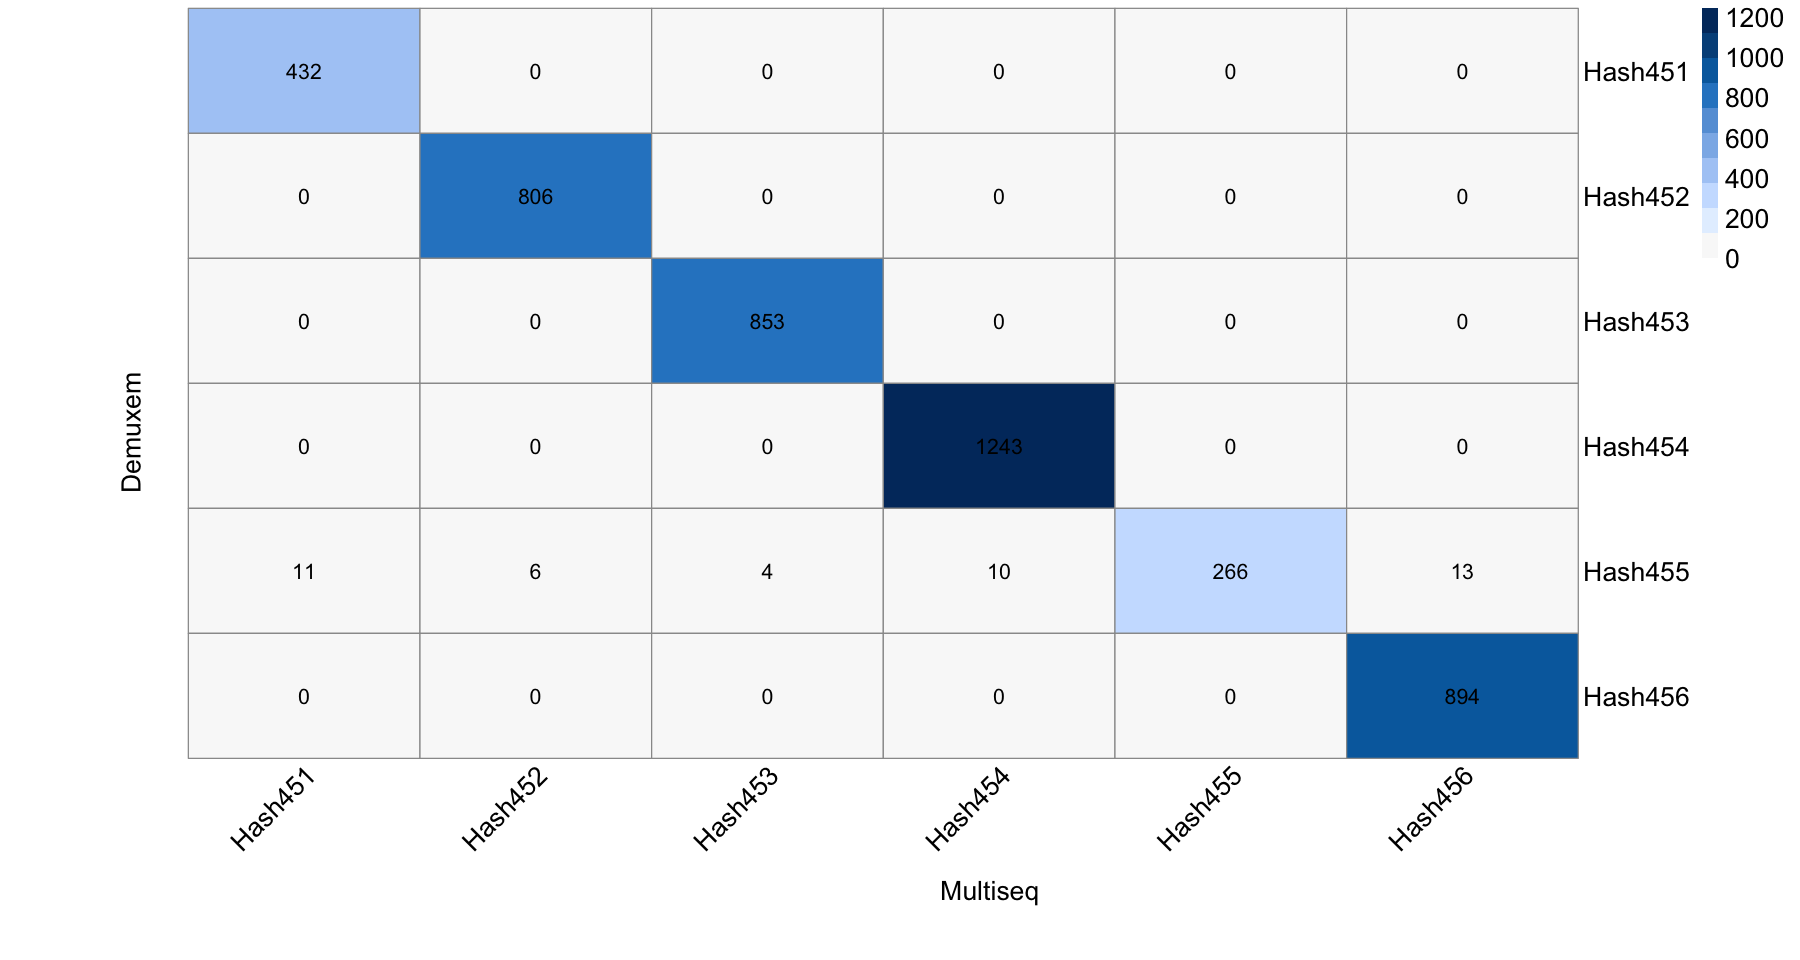

In [101]:
confusion_matrix_demuxem_multiseq = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_demuxem_multiseq) = donor_list 
colnames(confusion_matrix_demuxem_multiseq) = donor_list 

for (i in c(1:6)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$demuxem == donor_list[i] & 
                             hash_gene_result$multiseq == donor_list[j],])
    confusion_matrix_demuxem_multiseq[i, j] = row
    }}

confusion_matrix_demuxem_multiseq

png("S25-heatmap-multiseq-demuxem-gx38.png", res=300, width=15, height=15, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_demuxem_multiseq, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Multiseq", y=-0.03, gp=gpar(fontsize=16))
grid.text("Demuxem", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()

,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,194,0,3,0,0,0
Hash452,0,214,37,0,0,0
Hash453,0,0,345,0,0,0
Hash454,15,0,319,14,0,0
Hash455,5,0,162,0,44,0
Hash456,6,0,241,0,0,18


quartz_off_screen 
                3

quartz_off_screen 
                4

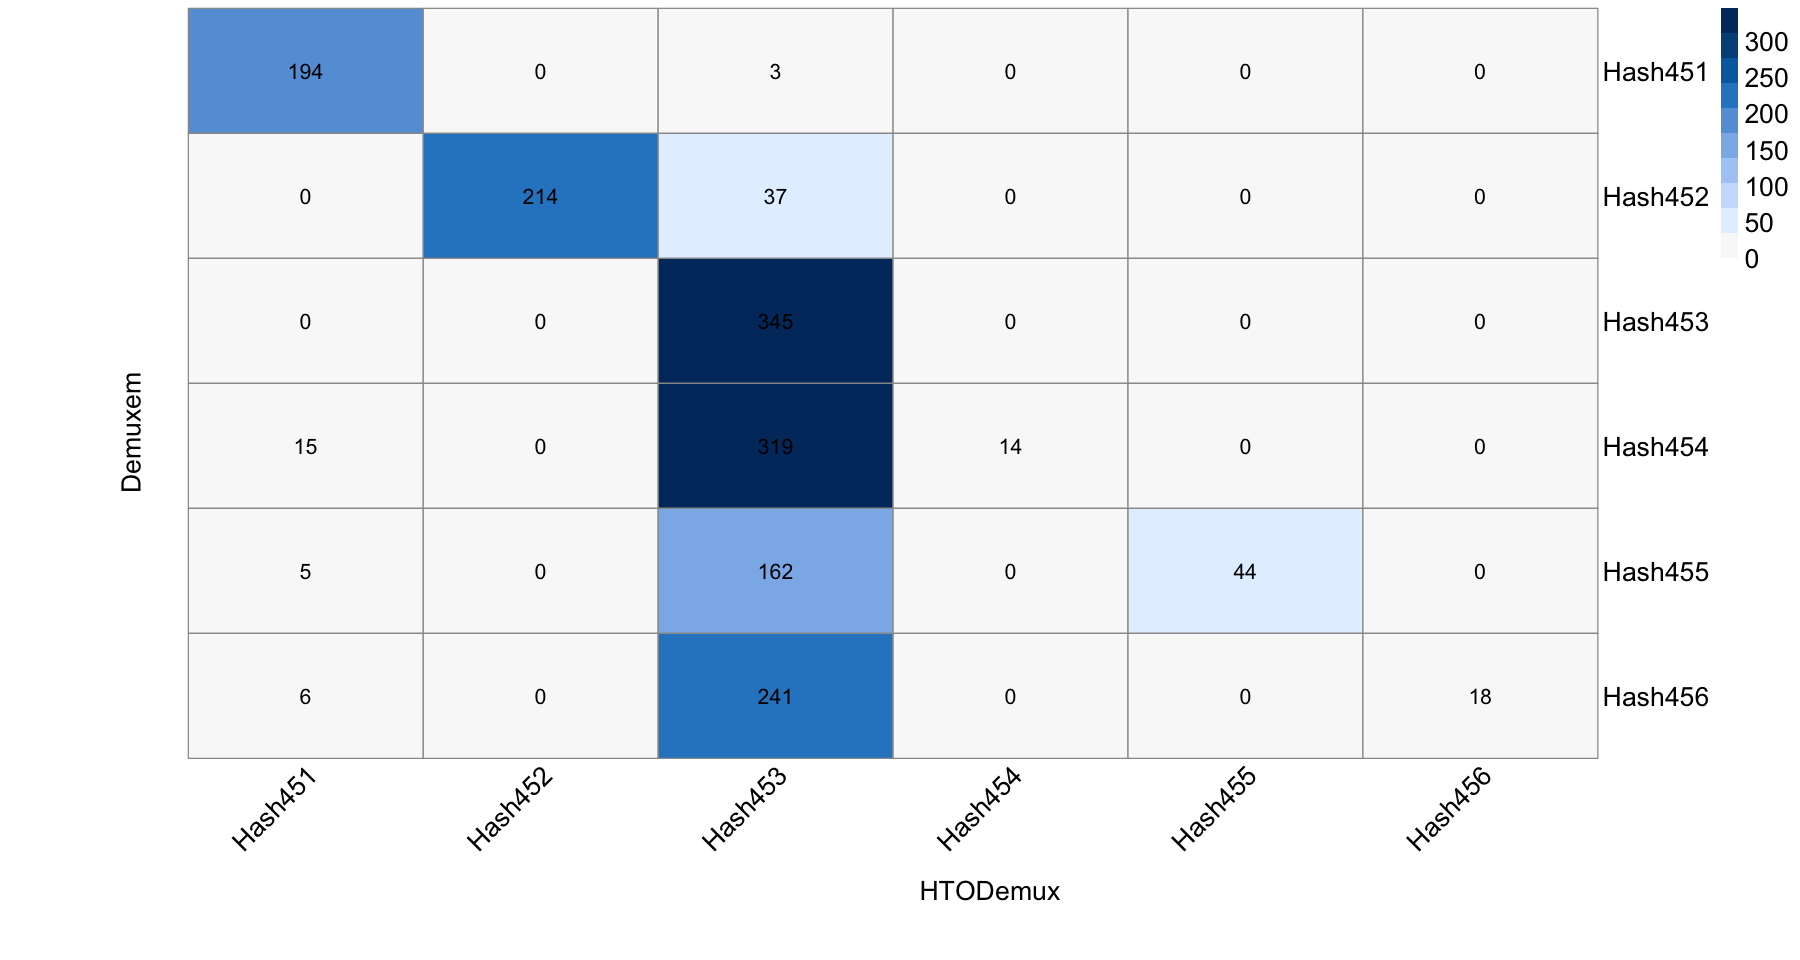

In [102]:
confusion_matrix_demuxem_htodemux = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_demuxem_htodemux) = donor_list 
colnames(confusion_matrix_demuxem_htodemux) = donor_list 

for (i in c(1:6)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$demuxem == donor_list[i] & 
                             hash_gene_result$htodemux == donor_list[j],])
    confusion_matrix_demuxem_htodemux[i, j] = row
    }}

confusion_matrix_demuxem_htodemux

png("S26-heatmap-htodemux-demuxem-gx38.png", res=300, width=15, height=15, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_demuxem_htodemux, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("HTODemux", y=-0.03, gp=gpar(fontsize=16))
grid.text("Demuxem", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()

,Hash451,Hash452,Hash453,Hash454,Hash455,Hash456
,<int>,<int>,<int>,<int>,<int>,<int>
Hash451,0,0,0,0,0,0
Hash452,3,3,315,0,0,0
Hash453,0,0,20,0,0,0
Hash454,0,0,34,0,0,0
Hash455,0,0,51,0,0,0
Hash456,0,0,36,0,0,0


quartz_off_screen 
                3

quartz_off_screen 
                4

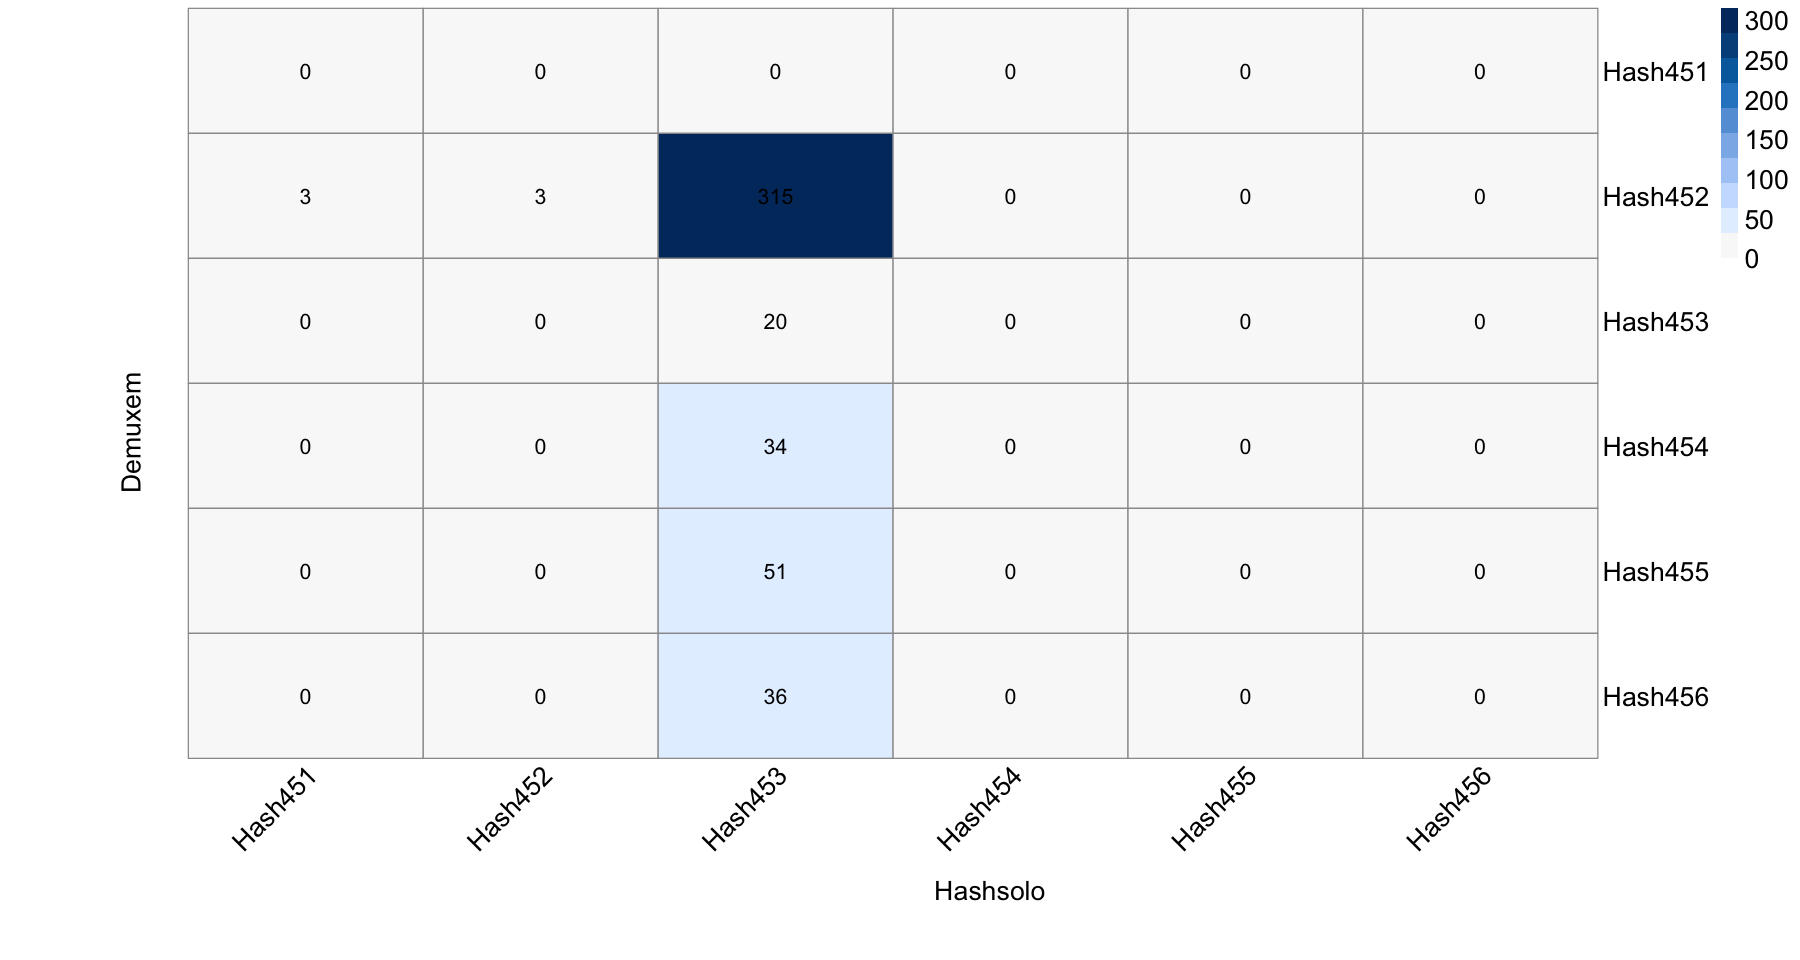

In [103]:
confusion_matrix_demuxem_hashsolo = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_demuxem_hashsolo) = donor_list 
colnames(confusion_matrix_demuxem_hashsolo) = donor_list 

for (i in c(1:6)){
  for (j in c(1:6)){
    row = nrow(hash_gene_result[hash_gene_result$demuxem == donor_list[i] & 
                             hash_gene_result$hashsolo == donor_list[j],])
    confusion_matrix_demuxem_hashsolo[i, j] = row
    }}

confusion_matrix_demuxem_hashsolo

png("S27-heatmap-hashsolo-demuxem-gx38.png", res=300, width=15, height=15, units="in")

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_demuxem_hashsolo, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="45",
         number_color = "black", fontsize = 16, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("Hashsolo", y=-0.03, gp=gpar(fontsize=16))
grid.text("Demuxem", x=-0.03, rot=90, gp=gpar(fontsize=16))
        
dev.copy()
dev.off()